# A Simple Cohort Retention Analysis in PyMC

## Prepare Notebook

In [1]:
import arviz as az
from datetime import datetime
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import numpy.typing as npt
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from scipy.special import expit
from sklearn.preprocessing import LabelEncoder, MinMaxScaler



plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/jax.py:37: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Generate Data

In [2]:
class CohortDataGenerator:
    def __init__(
        self,
        rng: np.random.Generator,
        start_cohort: str,
        n_cohorts,
        user_base: int = 10_000,
    ) -> None:
        self.rng = rng
        self.start_cohort = start_cohort
        self.n_cohorts = n_cohorts
        self.user_base = user_base

    def _generate_cohort_labels(self) -> pd.DatetimeIndex:
        return pd.period_range(
            start="2020-01-01", periods=self.n_cohorts, freq="M"
        ).to_timestamp()

    def _generate_cohort_sizes(self) -> npt.NDArray[np.int_]:
        ones = np.ones(shape=self.n_cohorts)
        trend = ones.cumsum() / ones.sum()
        return (
            (self.user_base * trend * self.rng.gamma(shape=1, scale=1, size=self.n_cohorts))
            .round()
            .astype(int)
        )

    def _generate_dataset_base(self) -> pd.DataFrame:
        cohorts = self._generate_cohort_labels()
        n_users = self._generate_cohort_sizes()
        data_df = pd.merge(
            left=pd.DataFrame(data={"cohort": cohorts, "n_users": n_users}),
            right=pd.DataFrame(data={"period": cohorts}),
            how="cross",
        )
        data_df["age"] = (data_df["period"].max() - data_df["cohort"]).dt.days
        data_df["cohort_age"] = (data_df["period"] - data_df["cohort"]).dt.days
        data_df = data_df.query("cohort_age >= 0")
        return data_df

    def _generate_retention_rates(self, data_df: pd.DataFrame) -> pd.DataFrame:
        data_df["retention_true_mu"] = (
            - data_df["cohort_age"] / (data_df["age"] + 1)
            + 0.8 * np.cos(2 * np.pi * data_df["period"].dt.dayofyear / 365)
            + 0.5 * np.sin(2 * 3 * np.pi * data_df["period"].dt.dayofyear / 365)
            - 0.5 * np.log1p(data_df["age"])
            + 1.0
        )
        data_df["retention_true"] = expit(data_df["retention_true_mu"])
        return data_df

    def _generate_user_history(self, data_df: pd.DataFrame) -> pd.DataFrame:
        data_df["n_active_users"] = rng.binomial(
            n=data_df["n_users"], p=data_df["retention_true"]
        )
        data_df["n_active_users"] = np.where(
            data_df["cohort_age"] == 0, data_df["n_users"], data_df["n_active_users"]
        )
        return data_df

    def run(
        self,
    ) -> pd.DataFrame:
        return (
            self._generate_dataset_base()
            .pipe(self._generate_retention_rates)
            .pipe(self._generate_user_history)
        )


In [3]:
seed: int = sum(map(ord, "retention"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

cohort_generator = CohortDataGenerator(rng=rng, start_cohort="2020-01-01", n_cohorts=48)
data_df = cohort_generator.run()

data_df.head()

cohort  n_users     period   age  cohort_age  retention_true_mu  \
0 2020-01-01      150 2020-01-01  1430           0          -1.807373   
1 2020-01-01      150 2020-02-01  1430          31          -1.474736   
2 2020-01-01      150 2020-03-01  1430          60          -2.281286   
3 2020-01-01      150 2020-04-01  1430          91          -3.206610   
4 2020-01-01      150 2020-05-01  1430         121          -3.112983   

   retention_true  n_active_users  
0        0.140956             150  
1        0.186224              25  
2        0.092685              13  
3        0.038918               6  
4        0.042575               2

In [4]:
data_df["retention"] = data_df["n_active_users"] / data_df["n_users"]

In [5]:
period_train_test_split = "2022-11-01"

train_data_df = data_df.query('period <= @period_train_test_split')
test_data_df = data_df.query('period > @period_train_test_split')
test_data_df = test_data_df[test_data_df["cohort"].isin(train_data_df['cohort'].unique())]

## EDA

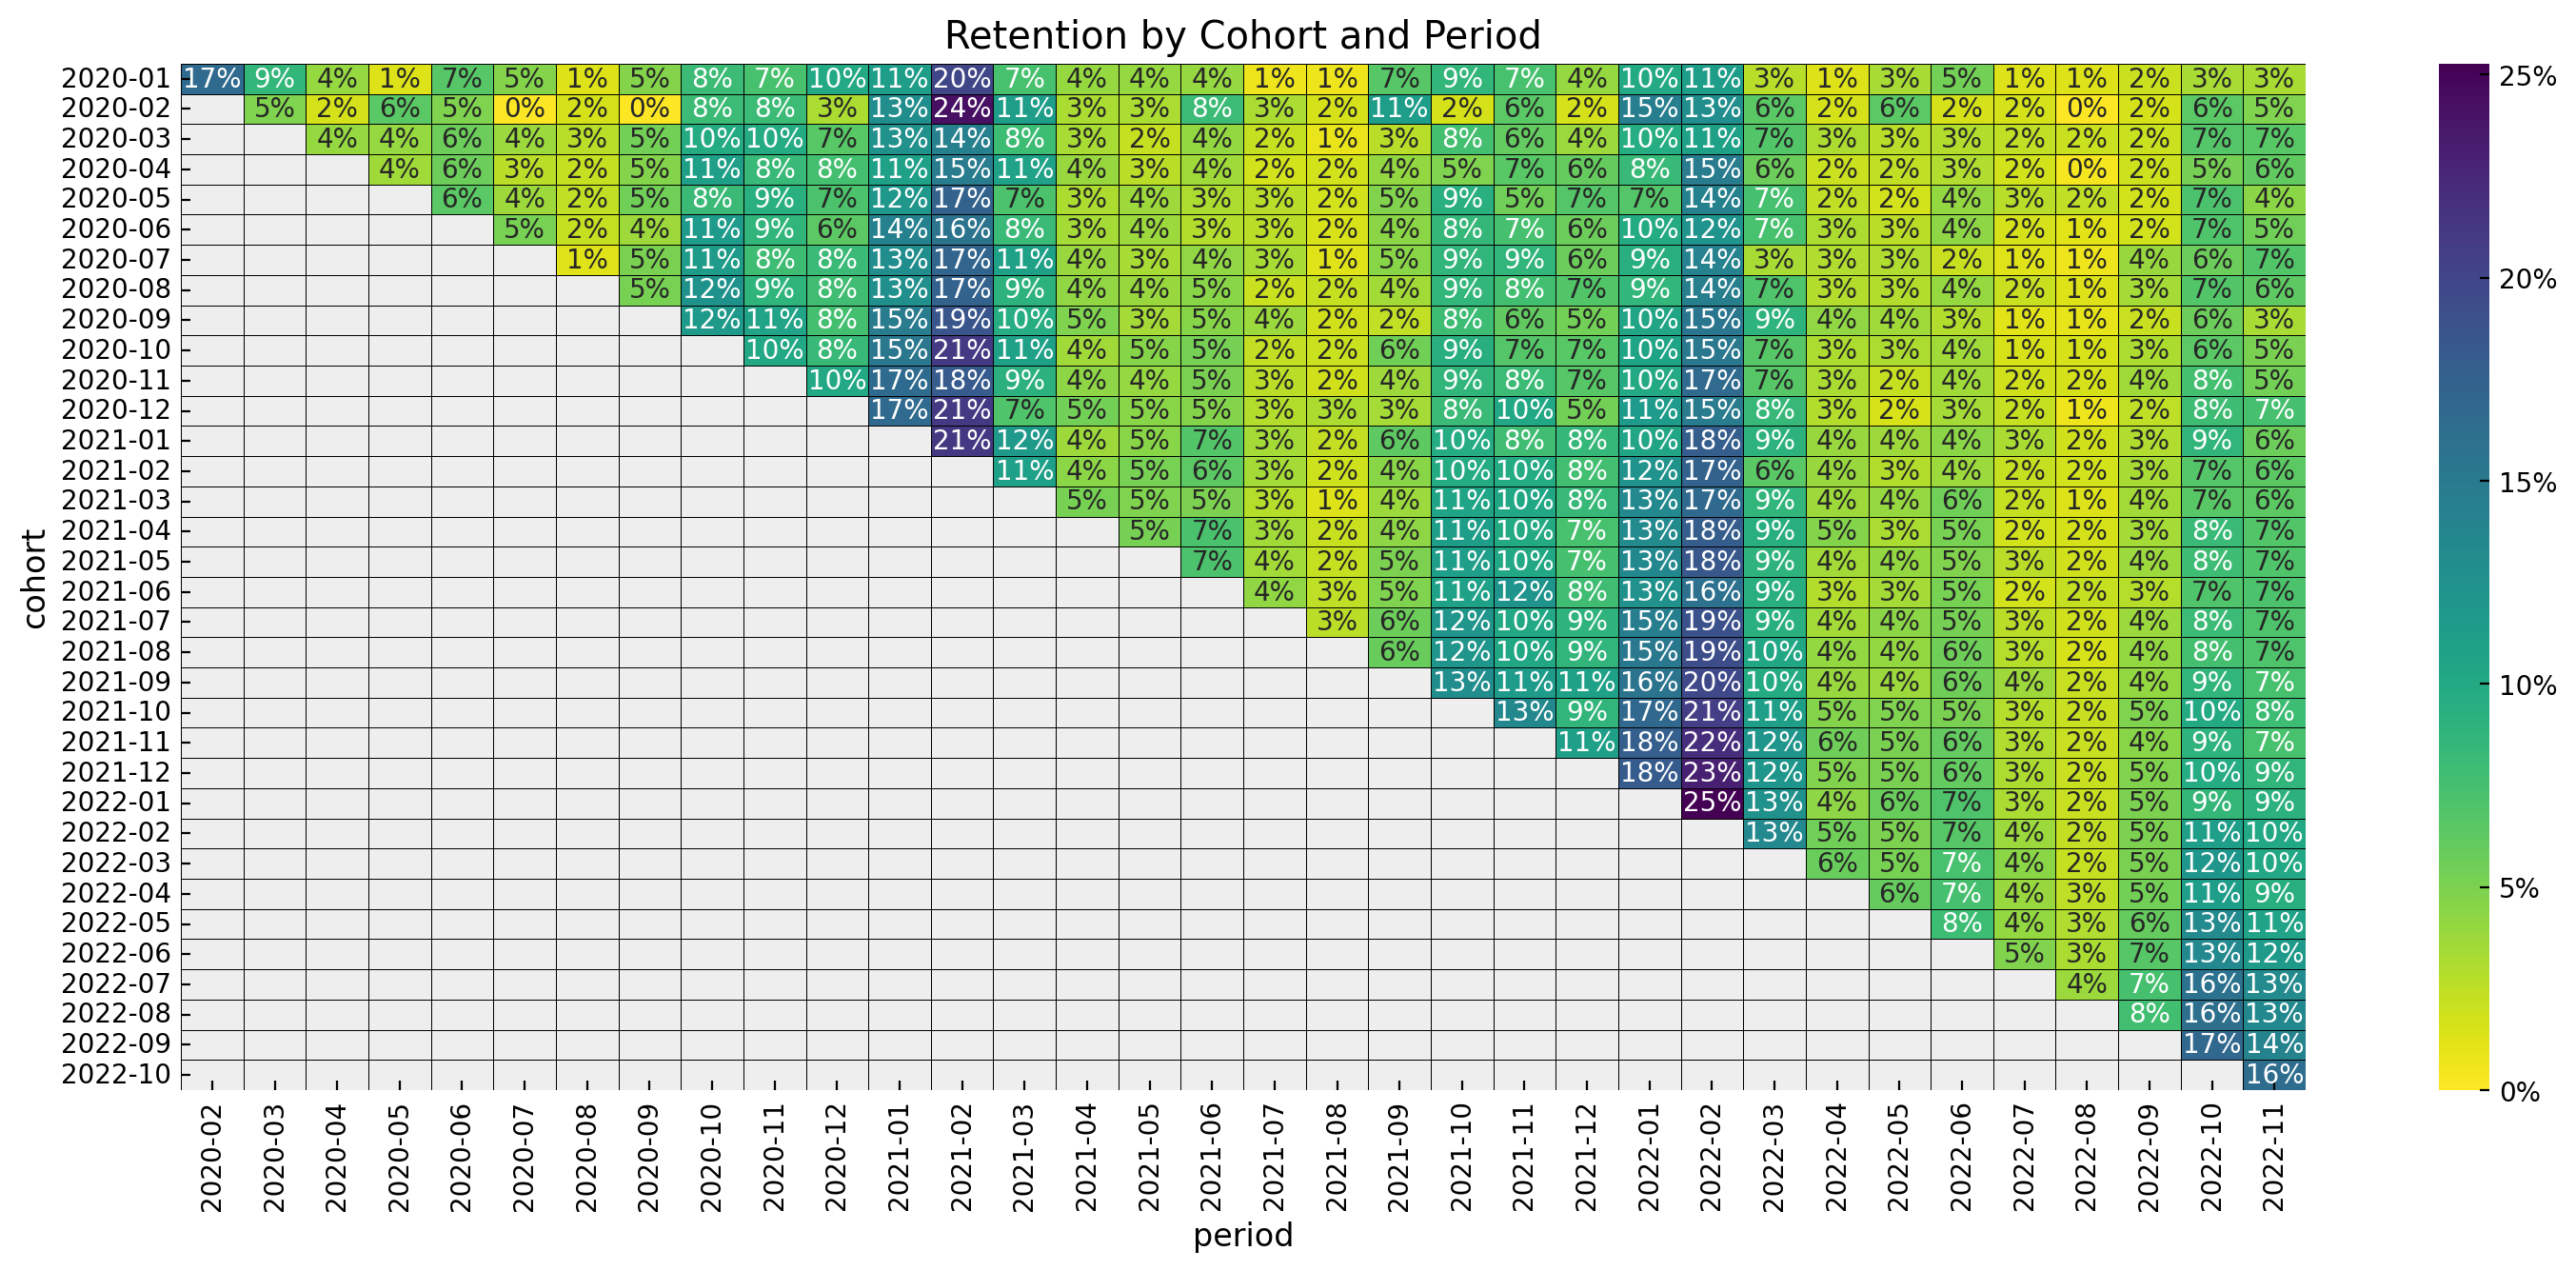

In [6]:
fig, ax = plt.subplots(figsize=(18, 7))

fmt = lambda y, _: f"{y :0.0%}"

(
    train_data_df.assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m"),
    )
    .query("cohort_age != 0")
    .filter(["cohort", "period", "retention"])
    .pivot(index="cohort", columns="period", values="retention")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(fmt)},
        ax=ax,
    )
)

ax.set_title("Retention by Cohort and Period");

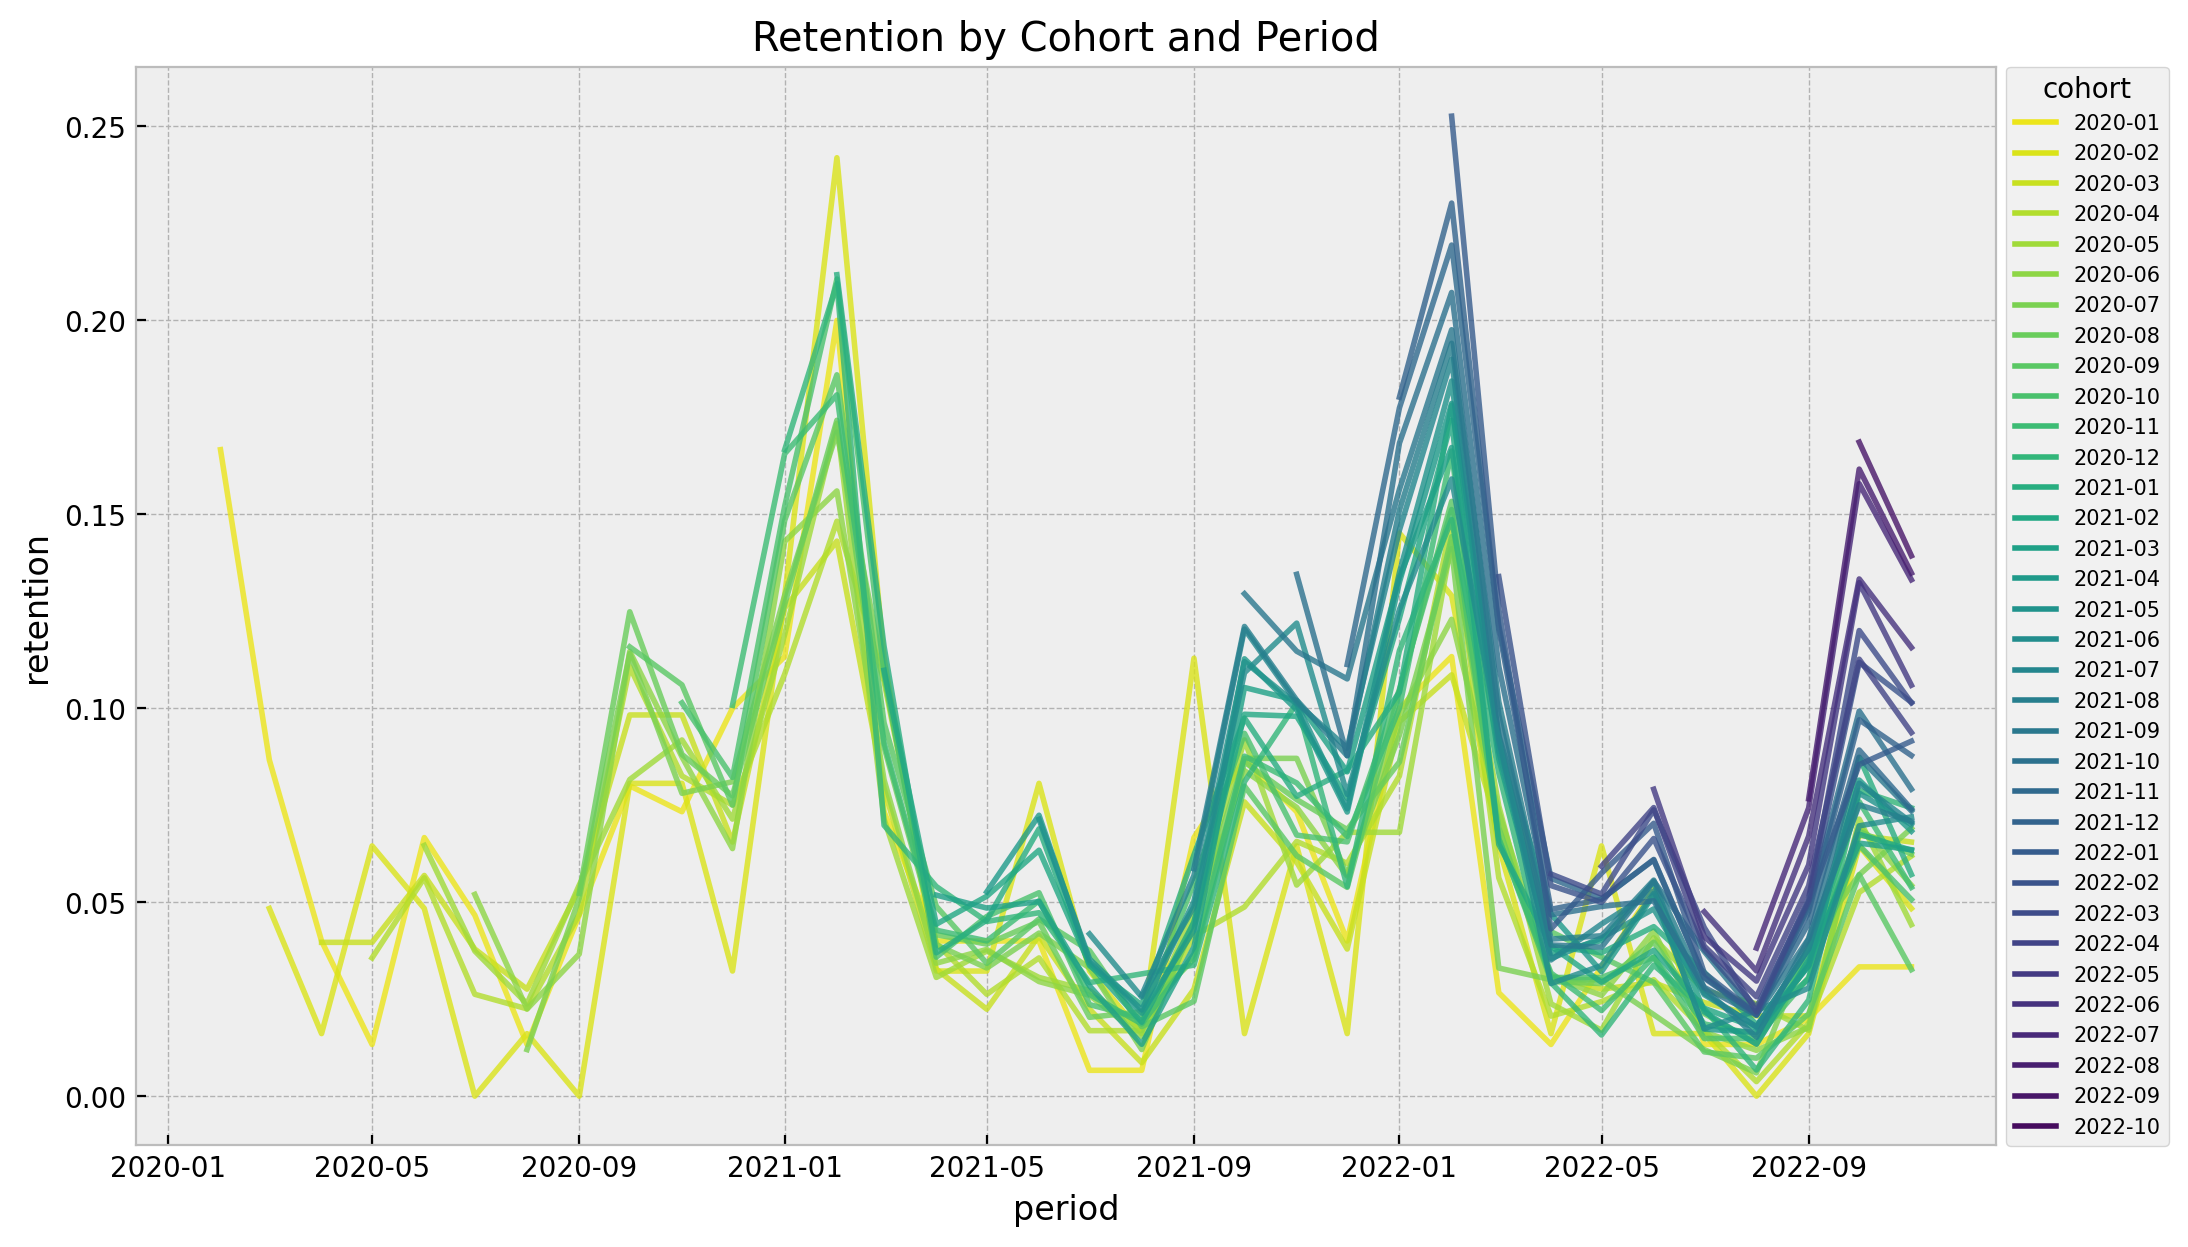

In [7]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    alpha=0.8,
    data=train_data_df.query("cohort_age > 0").assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m")
    ),
    ax=ax,
)
ax.legend(title="cohort", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set(title="Retention by Cohort and Period");

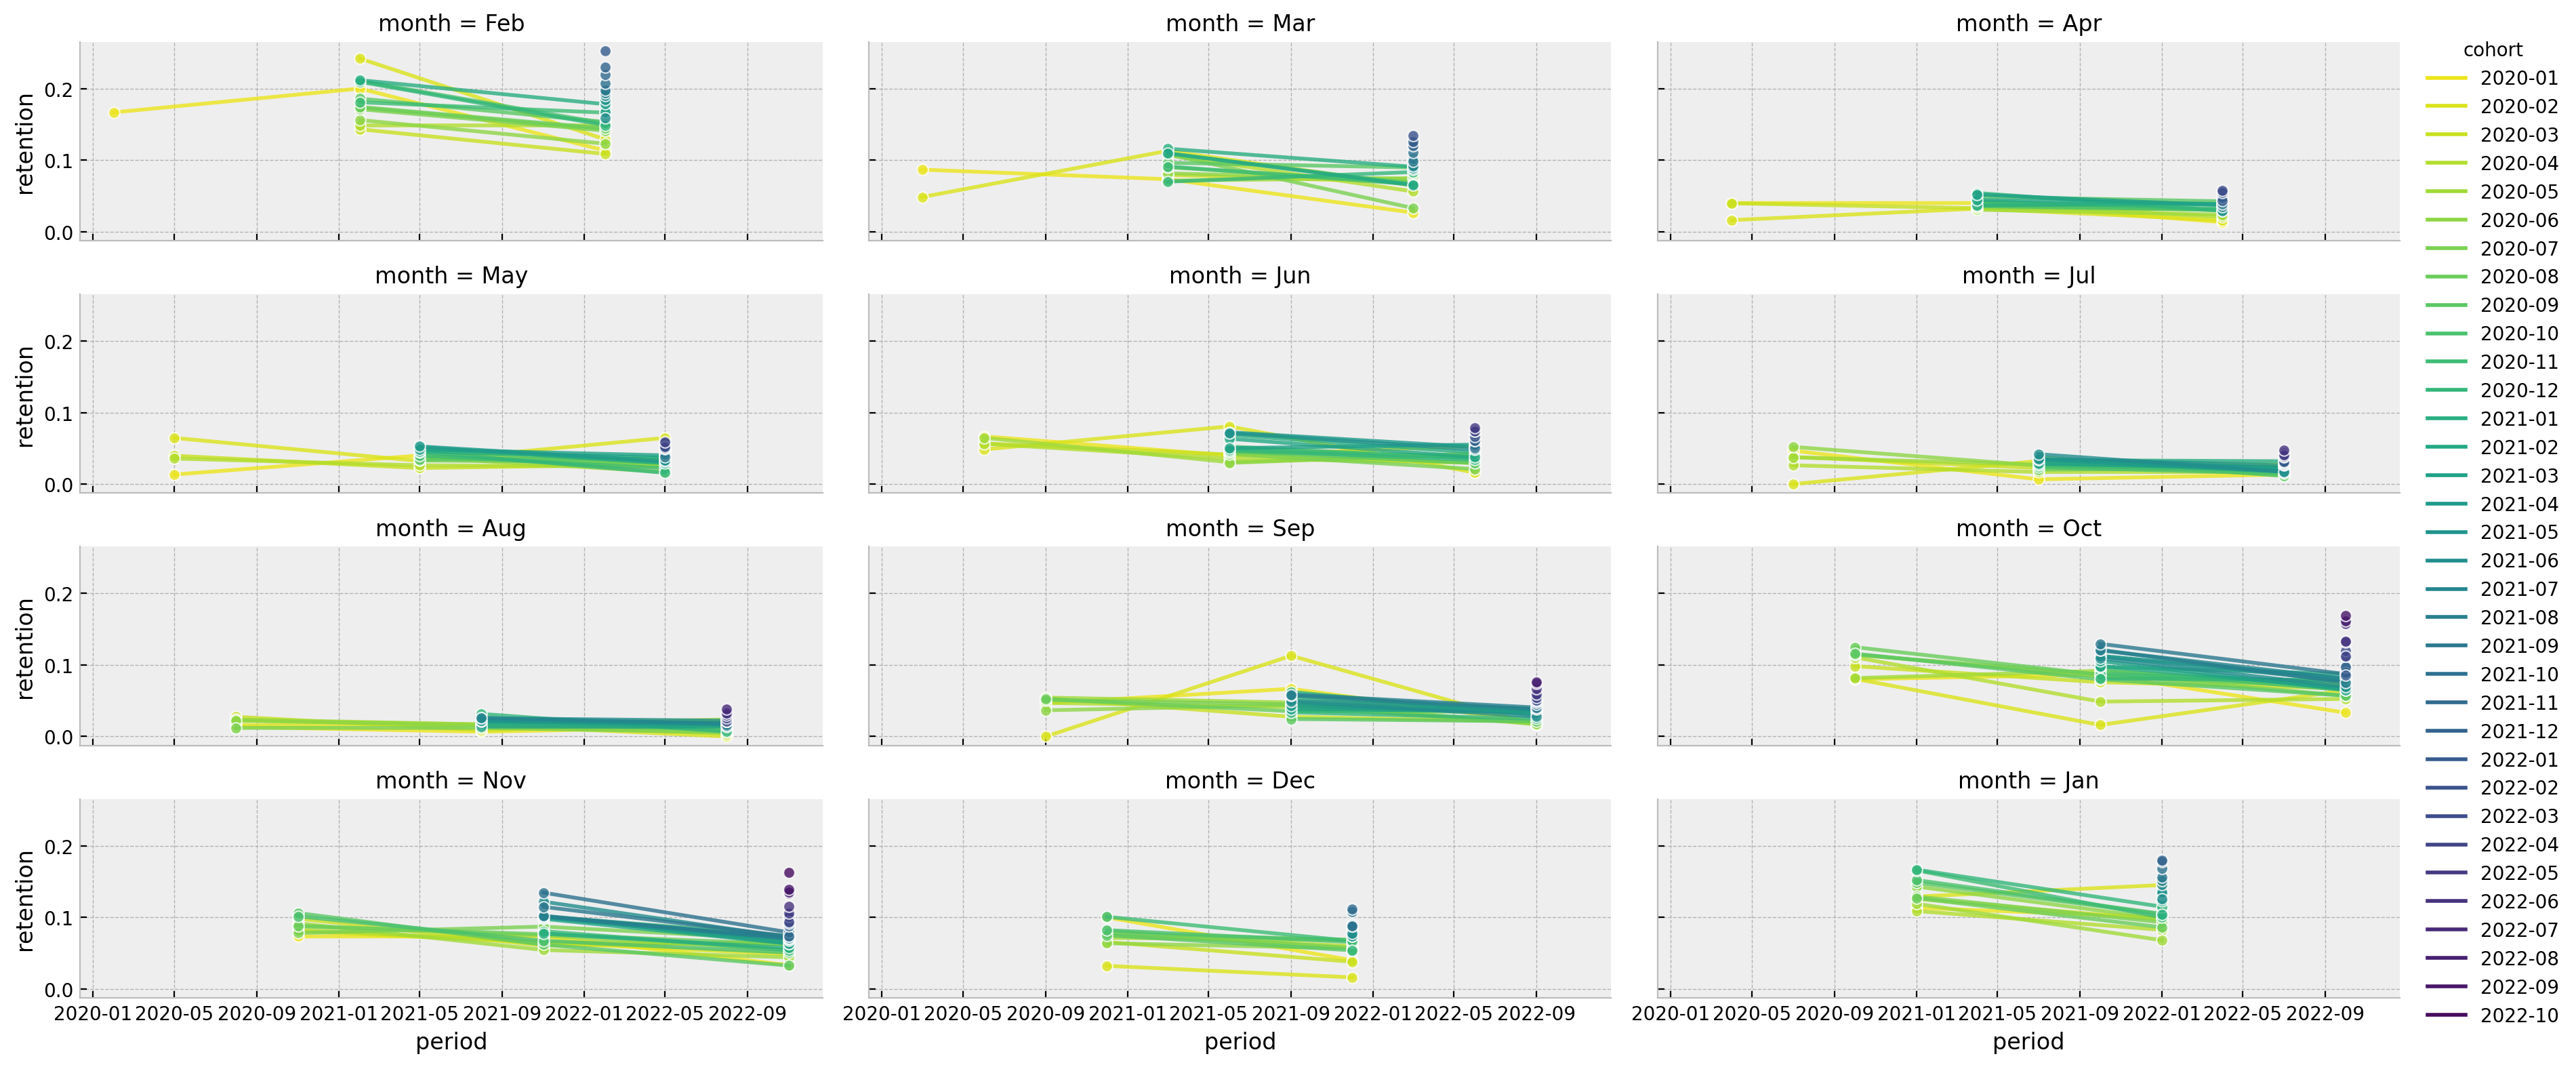

In [8]:
g = sns.relplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    col="month",
    col_wrap=3,
    kind="line",
    marker="o",
    alpha=0.8,
    data=train_data_df.query("cohort_age > 0").assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        month=lambda df: df["period"].dt.strftime("%b")
    ),
    height=2,
    aspect=3,
    facet_kws={"sharex": True, "sharey": True},
)

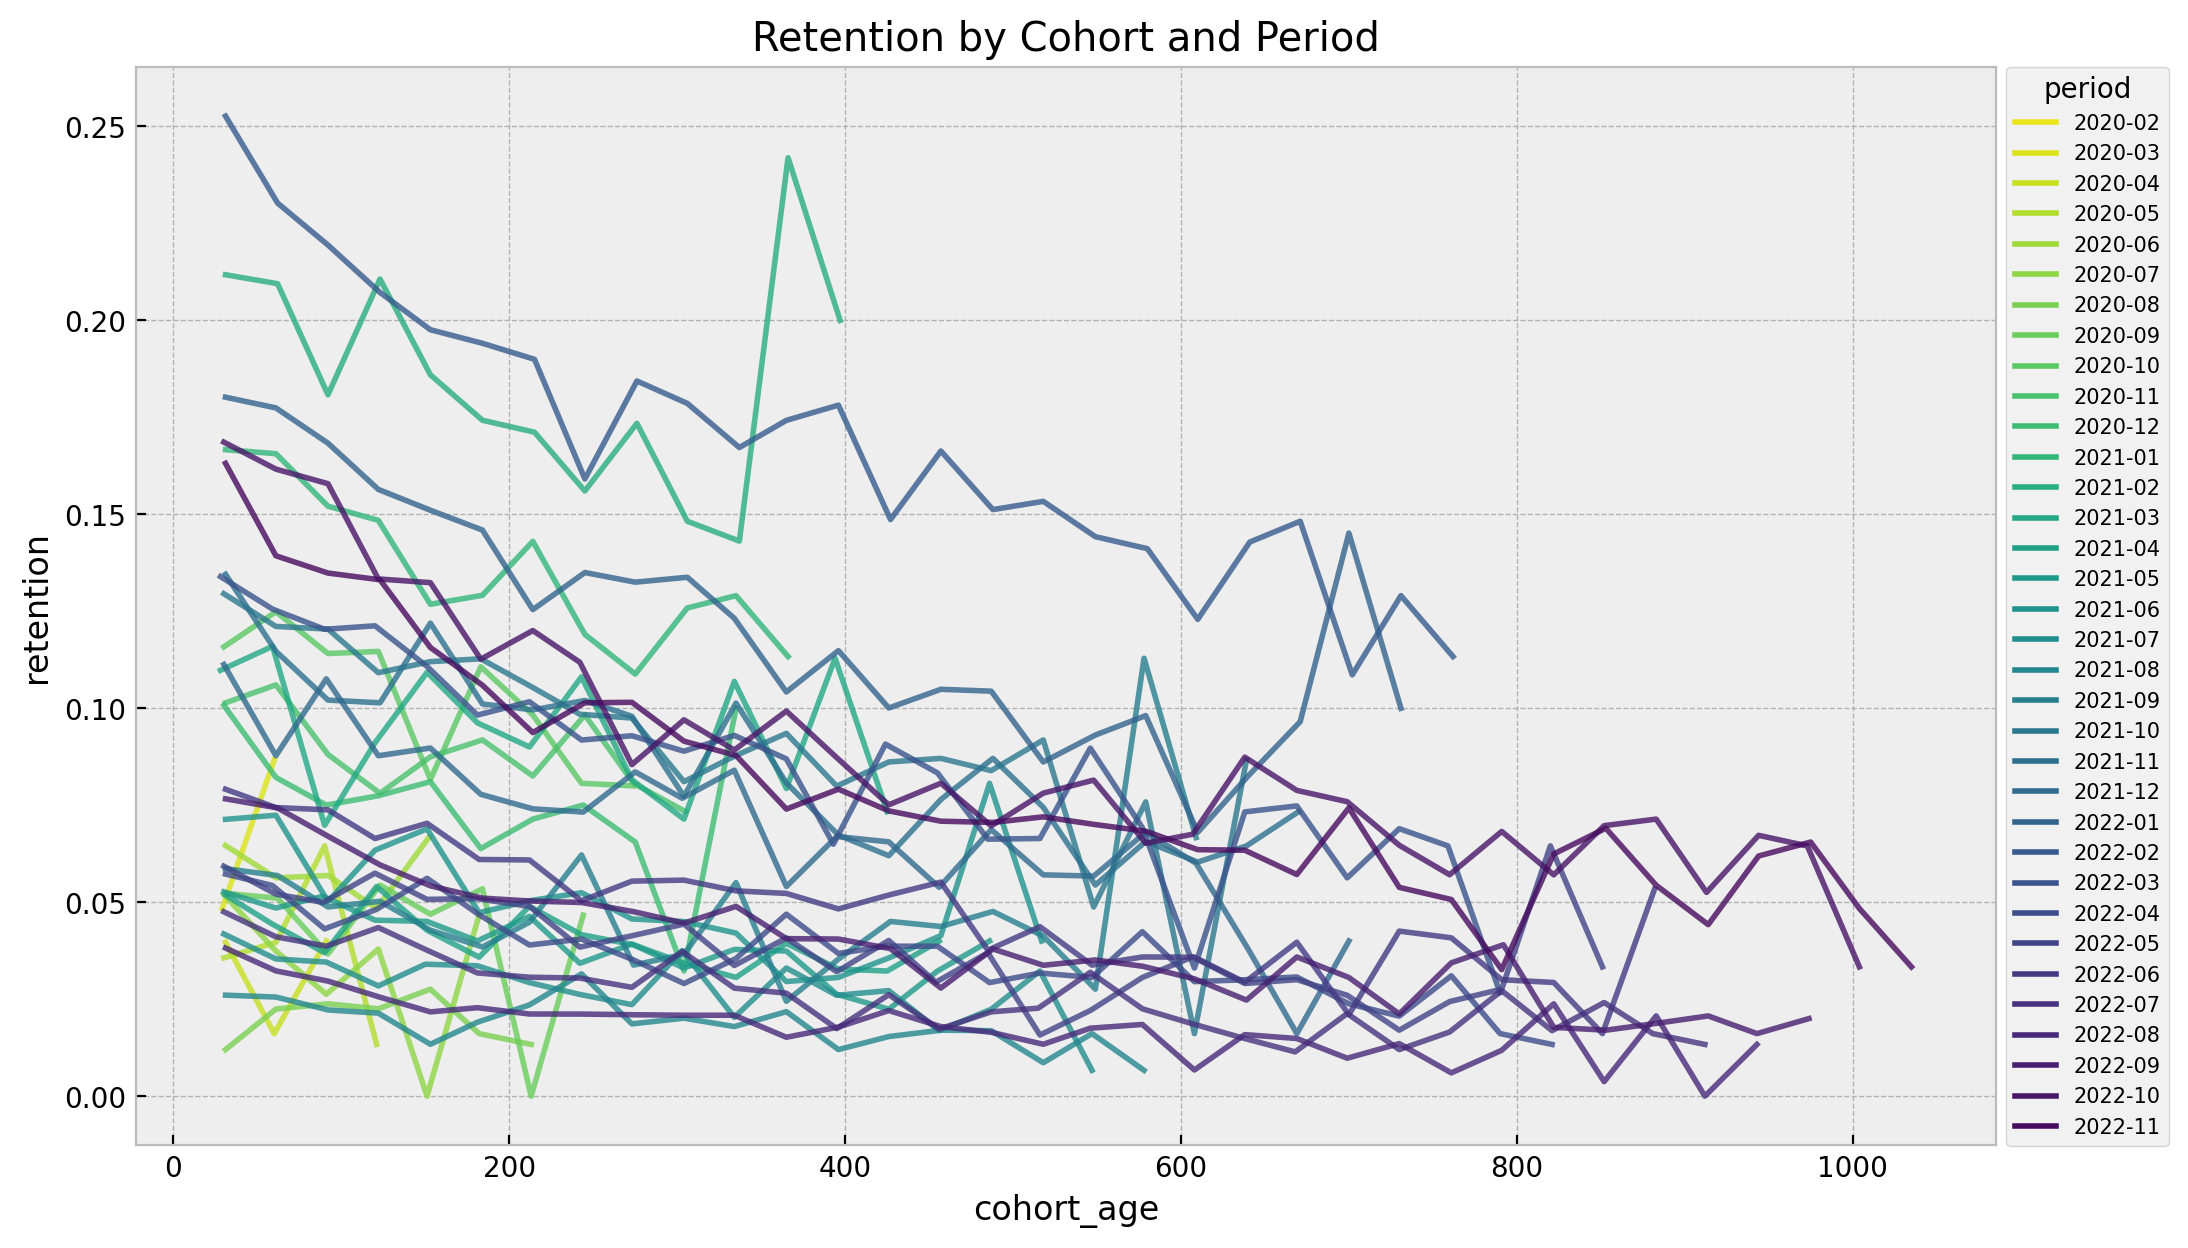

In [9]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(
    x="cohort_age",
    y="retention",
    hue="period",
    palette="viridis_r",
    alpha=0.8,
    data=train_data_df.query("cohort_age > 0").assign(
        period=lambda df: df["period"].dt.strftime("%Y-%m")
    ),
    ax=ax,
)
ax.legend(title="period", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set(title="Retention by Cohort and Period");

## Model

In [10]:
data_df.head()

cohort  n_users     period   age  cohort_age  retention_true_mu  \
0 2020-01-01      150 2020-01-01  1430           0          -1.807373   
1 2020-01-01      150 2020-02-01  1430          31          -1.474736   
2 2020-01-01      150 2020-03-01  1430          60          -2.281286   
3 2020-01-01      150 2020-04-01  1430          91          -3.206610   
4 2020-01-01      150 2020-05-01  1430         121          -3.112983   

   retention_true  n_active_users  retention  
0        0.140956             150   1.000000  
1        0.186224              25   0.166667  
2        0.092685              13   0.086667  
3        0.038918               6   0.040000  
4        0.042575               2   0.013333

In [11]:
train_data_red_df = train_data_df.query("cohort_age > 0").reset_index(drop=True)
train_obs_idx = train_data_red_df.index.to_numpy()
train_n_users = train_data_red_df["n_users"].to_numpy()
train_n_active_users = train_data_red_df["n_active_users"].to_numpy()
train_retention = train_data_red_df["retention"].to_numpy()

# Continuous features
train_age = train_data_red_df["age"].to_numpy()
train_age_scaler = MinMaxScaler()
train_age_scaled = train_age_scaler.fit_transform(train_age.reshape(-1, 1)).flatten()
train_cohort_age = train_data_red_df["cohort_age"].to_numpy()
train_cohort_age_scaler = MinMaxScaler()
train_cohort_age_scaled = train_cohort_age_scaler.fit_transform(train_cohort_age.reshape(-1, 1)).flatten()

# Categorical features
train_cohort = train_data_red_df["cohort"].to_numpy()
train_cohort_encoder = LabelEncoder()
train_cohort_idx = train_cohort_encoder.fit_transform(train_cohort).flatten()
train_period = train_data_red_df["period"].to_numpy()
train_period_encoder = LabelEncoder()
train_period_idx = train_period_encoder.fit_transform(train_period).flatten()
train_period_month = train_data_red_df["period"].dt.month.to_numpy()
train_period_month_encoder = LabelEncoder()
train_period_month_idx = train_period_month_encoder.fit_transform(train_period_month).flatten()

coords: dict[str, npt.NDArray] = {
    "period_month": train_period_month_encoder.classes_,
}

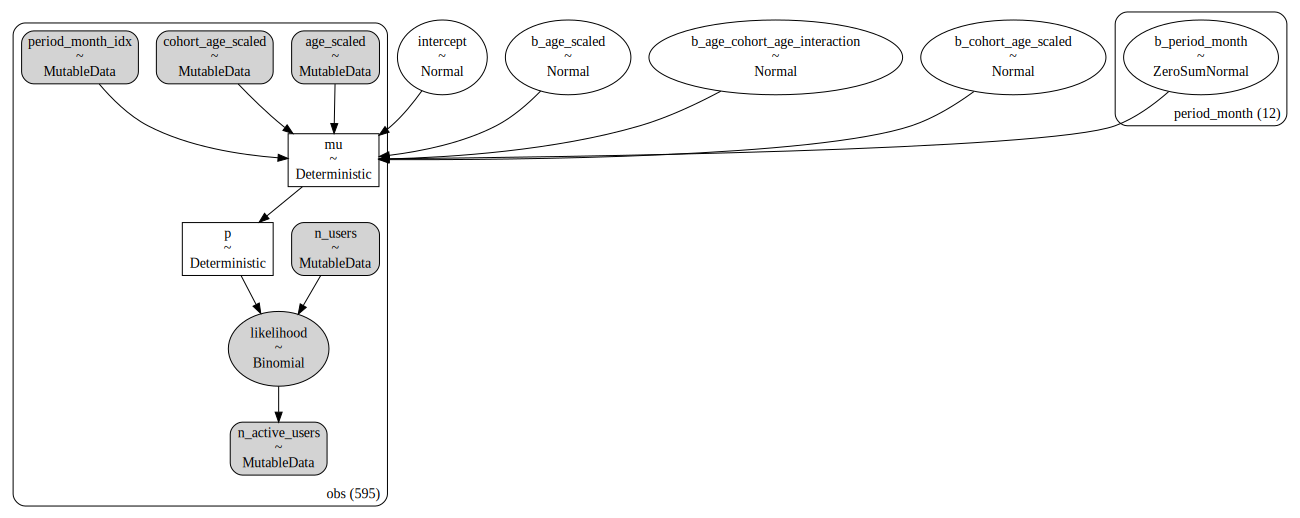

In [12]:
with pm.Model(coords=coords) as model:
    # --- Data ---
    model.add_coord(name="obs", values=train_obs_idx, mutable=True)
    age_scaled = pm.MutableData(name="age_scaled", value=train_age_scaled, dims="obs")
    cohort_age_scaled = pm.MutableData(
        name="cohort_age_scaled", value=train_cohort_age_scaled, dims="obs"
    )
    period_month_idx = pm.MutableData(name="period_month_idx", value=train_period_month_idx, dims="obs")
    n_users = pm.MutableData(name="n_users", value=train_n_users, dims="obs")
    n_active_users = pm.MutableData(name="n_active_users", value=train_n_active_users, dims="obs")

    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    b_age_scaled = pm.Normal(name="b_age_scaled", mu=0, sigma=1)
    b_cohort_age_scaled = pm.Normal(name="b_cohort_age_scaled", mu=0, sigma=1)
    b_period_month = pm.ZeroSumNormal(
        name="b_period_month", sigma=1, dims="period_month"
    )
    b_age_cohort_age_interaction = pm.Normal(
        name="b_age_cohort_age_interaction", mu=0, sigma=1
    )

    # --- Parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=intercept
        + b_age_scaled * age_scaled
        + b_cohort_age_scaled * cohort_age_scaled
        + b_age_cohort_age_interaction * age_scaled * cohort_age_scaled
        + b_period_month[period_month_idx],
        dims="obs",
    )

    p = pm.Deterministic(name="p", var=pm.math.invlogit(mu), dims="obs")

    # --- Likelihood ---
    pm.Binomial(
        name="likelihood",
        n=n_users,
        p=p,
        observed=n_active_users,
        dims="obs",
    )

pm.model_to_graphviz(model=model)

In [13]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(
        target_accept=0.8, draws=2_000, chains=4
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:05.005934
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:08.407861
Transforming variables...


Sampling: [likelihood]
INFO:pymc:Sampling: [likelihood]


Transformation time =  0:00:01.154811


In [14]:
az.summary(data=idata, var_names=["~intercept", "~mu", "~p"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
b_age_scaled                 -0.536  0.026  -0.582   -0.486      0.000   
b_cohort_age_scaled          -1.772  0.069  -1.904   -1.646      0.001   
b_age_cohort_age_interaction  1.213  0.098   1.035    1.399      0.001   
b_period_month[1]             0.807  0.012   0.784    0.830      0.000   
b_period_month[2]             1.178  0.011   1.158    1.199      0.000   
b_period_month[3]             0.406  0.013   0.382    0.430      0.000   
b_period_month[4]            -0.507  0.018  -0.541   -0.473      0.000   
b_period_month[5]            -0.462  0.017  -0.495   -0.430      0.000   
b_period_month[6]            -0.182  0.014  -0.206   -0.154      0.000   
b_period_month[7]            -0.807  0.016  -0.838   -0.777      0.000   
b_period_month[8]            -1.182  0.019  -1.219   -1.147      0.000   
b_period_month[9]            -0.351  0.013  -0.374   -0.326      0.000   
b_period_month[10]            0.511  0.009   0.493    0.529      0.000   
b_period_month[11]            0.394  0.010   0.376    0.413      0.000   
b_period_month[12]            0.195  0.017   0.163    0.228      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
b_age_scaled                    0.000    6128.0    6022.0    1.0  
b_cohort_age_scaled             0.001    5393.0    5943.0    1.0  
b_age_cohort_age_interaction    0.001    4993.0    5795.0    1.0  
b_period_month[1]               0.000   13038.0    5723.0    1.0  
b_period_month[2]               0.000   12619.0    6095.0    1.0  
b_period_month[3]               0.000   13229.0    5809.0    1.0  
b_period_month[4]               0.000   13207.0    5576.0    1.0  
b_period_month[5]               0.000   13759.0    5608.0    1.0  
b_period_month[6]               0.000   15335.0    5608.0    1.0  
b_period_month[7]               0.000   13250.0    5547.0    1.0  
b_period_month[8]               0.000   13755.0    4852.0    1.0  
b_period_month[9]               0.000   13935.0    5578.0    1.0  
b_period_month[10]              0.000   12729.0    5916.0    1.0  
b_period_month[11]              0.000   13018.0    6547.0    1.0  
b_period_month[12]              0.000    9125.0    5634.0    1.0

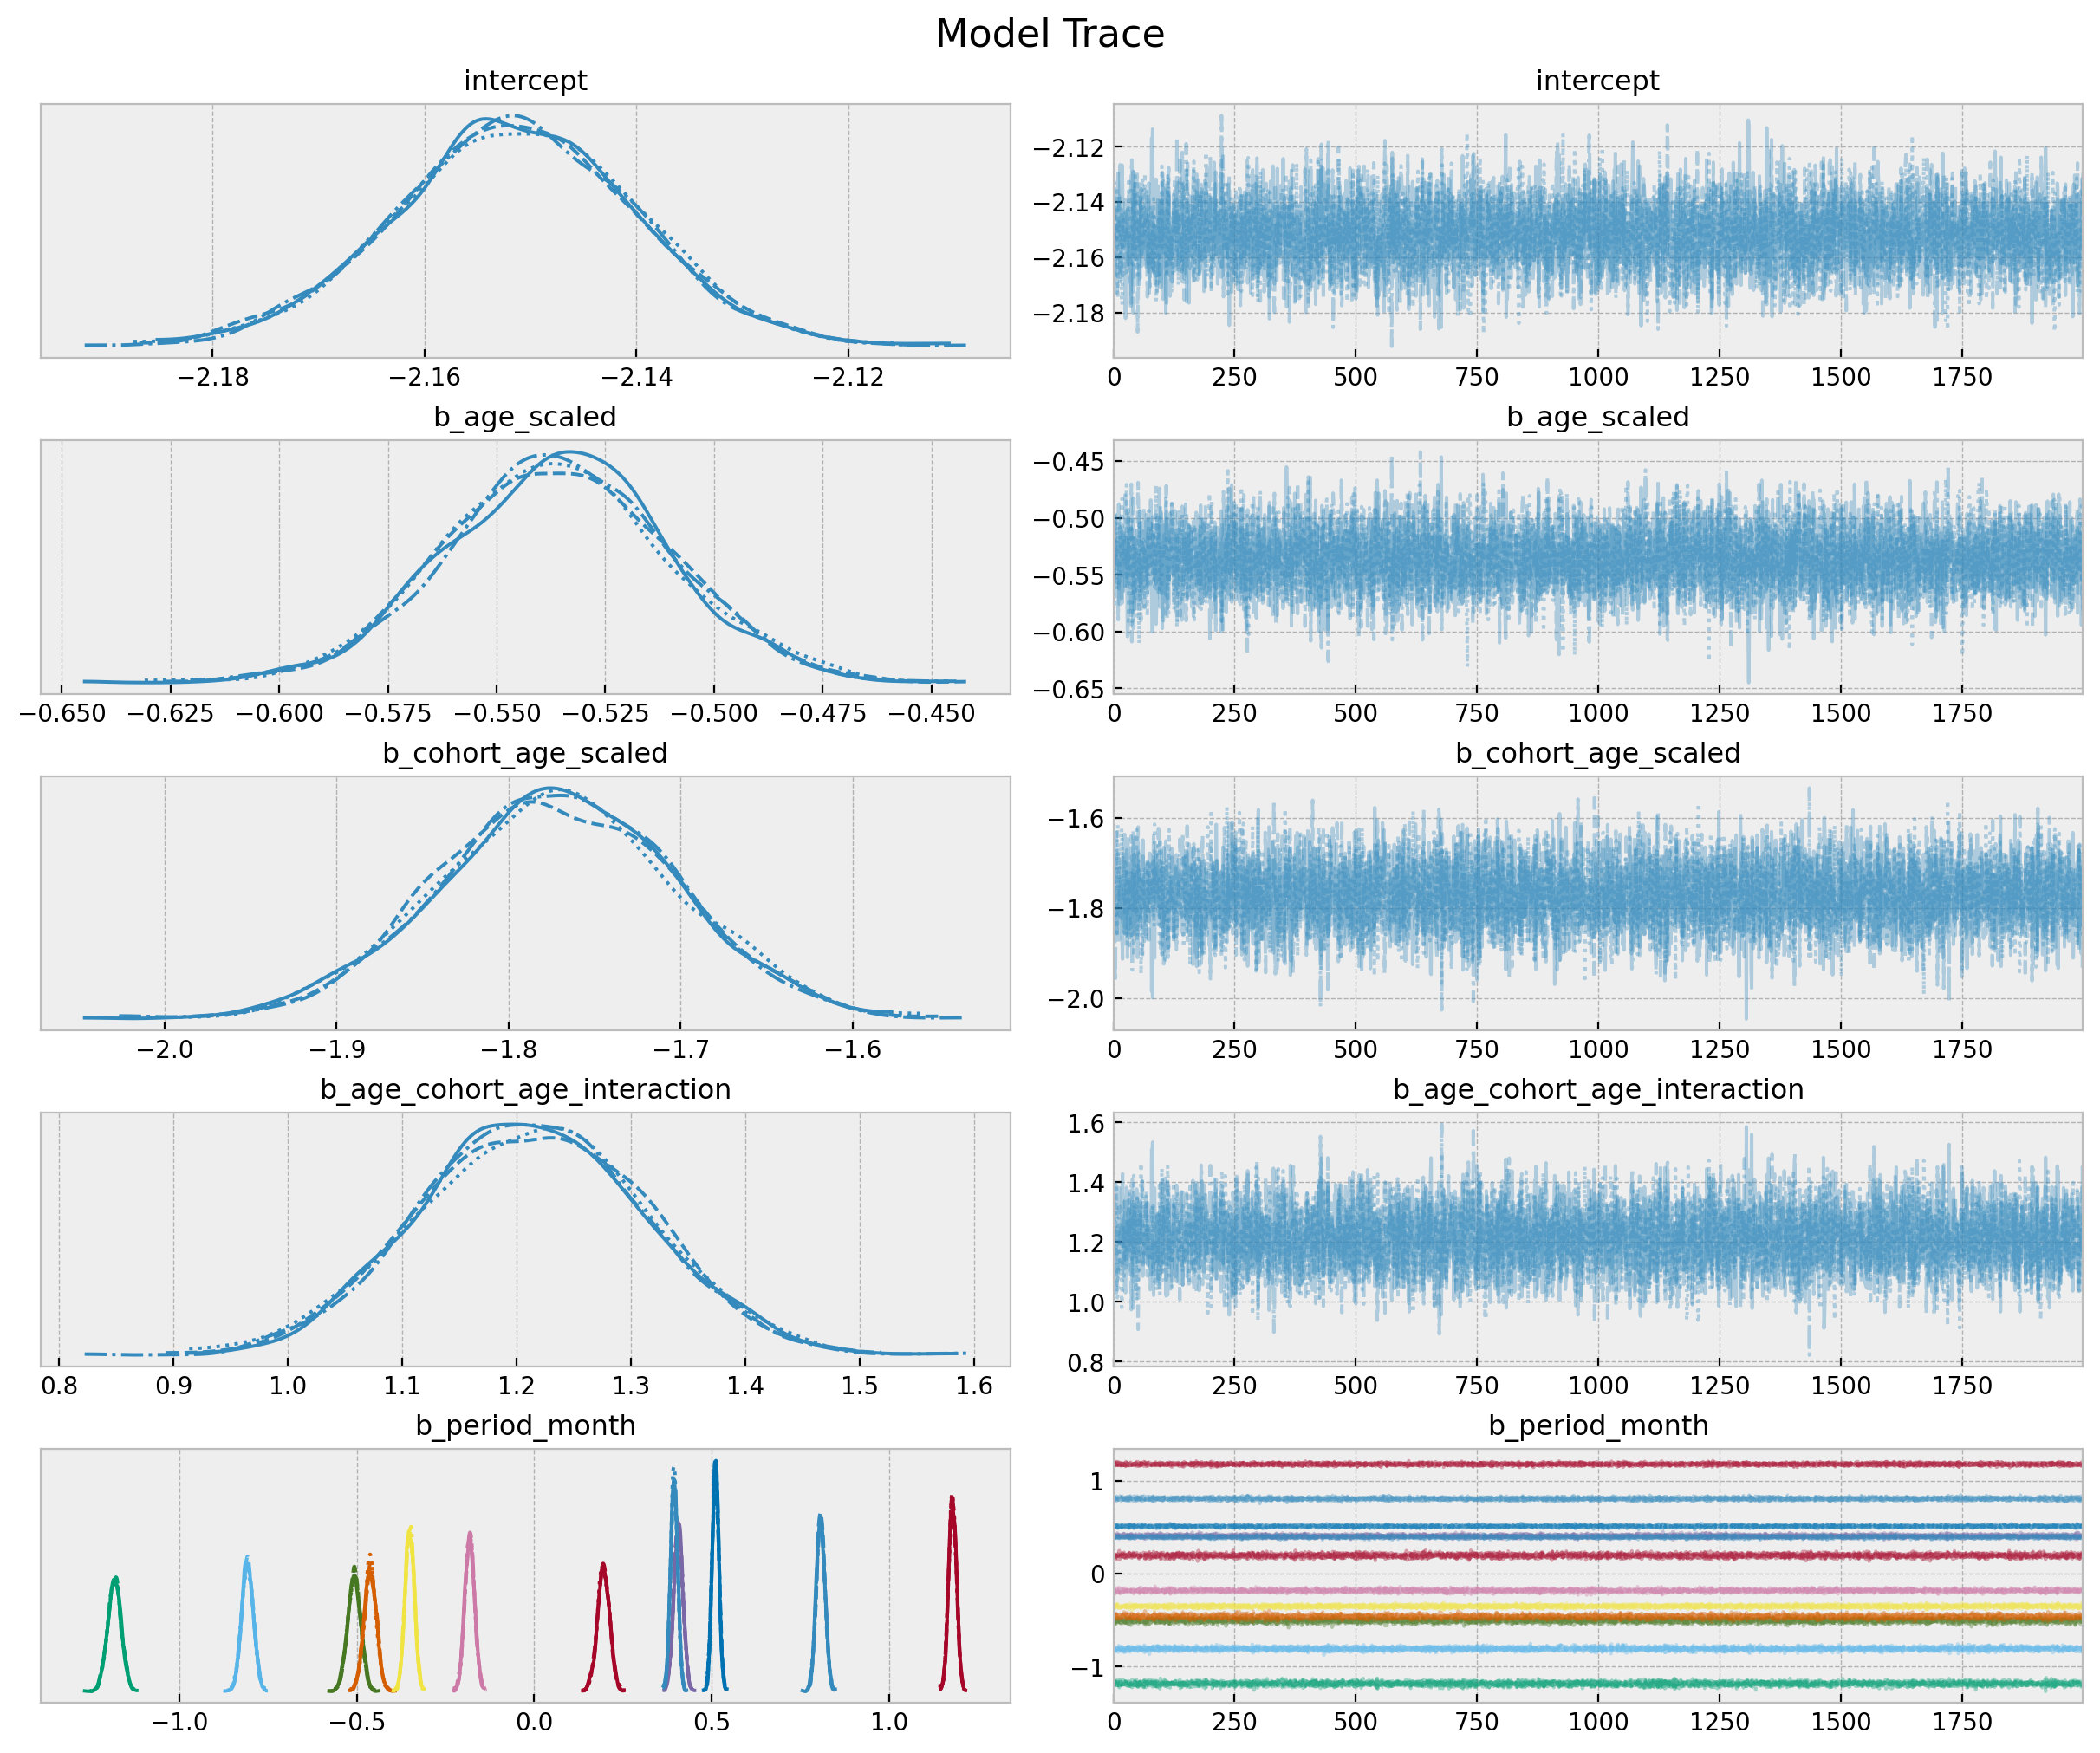

In [15]:
axes = az.plot_trace(
    data=idata,
    var_names=["~mu", "~p"],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

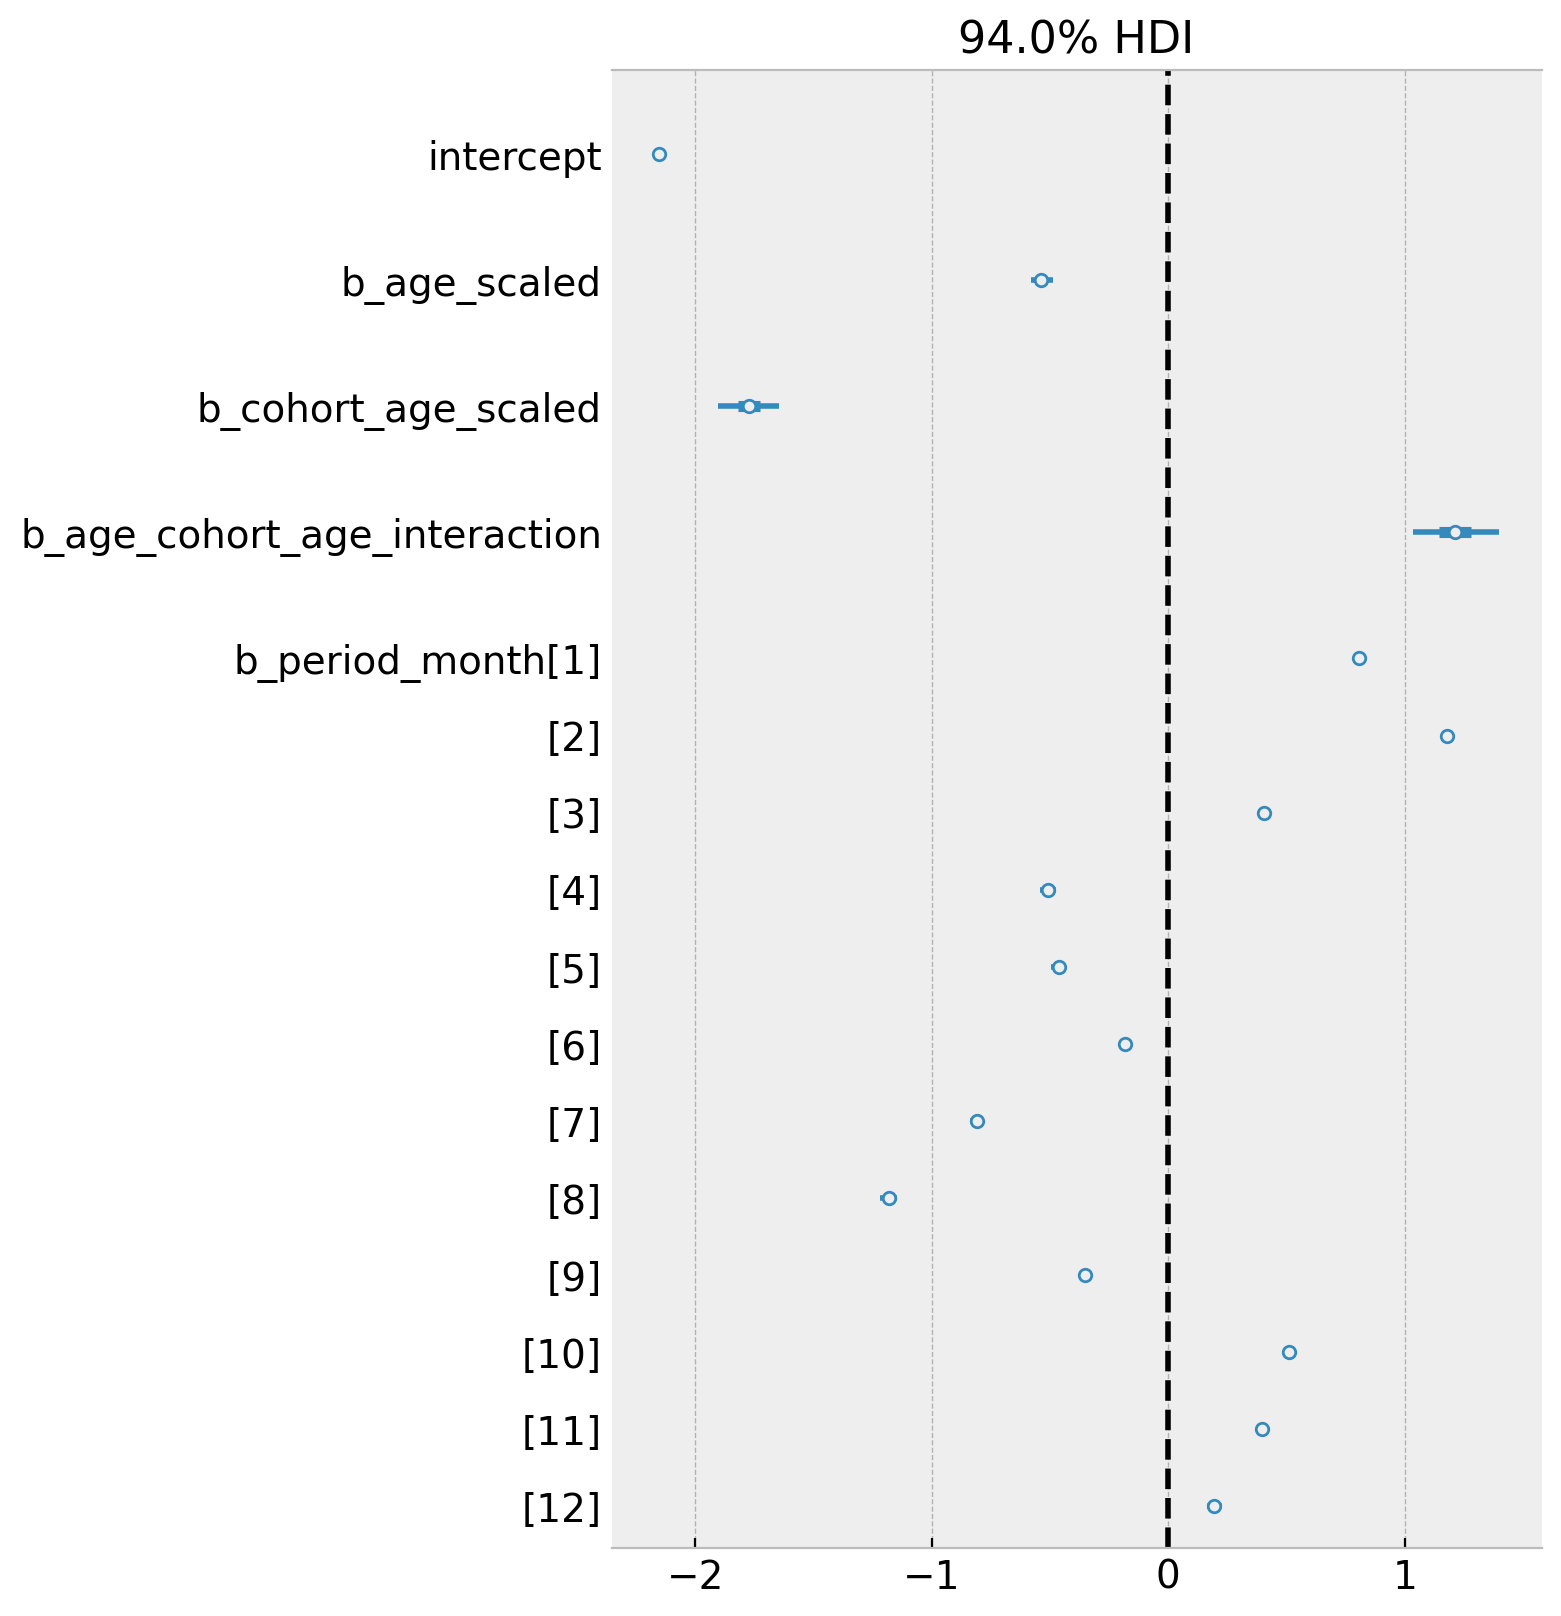

In [16]:
ax, *_ = az.plot_forest(data=idata, var_names=["~mu", "~p"], combined=True)
ax.axvline(x=0, color="black", linestyle="--")

<AxesSubplot: xlabel='likelihood / likelihood'>

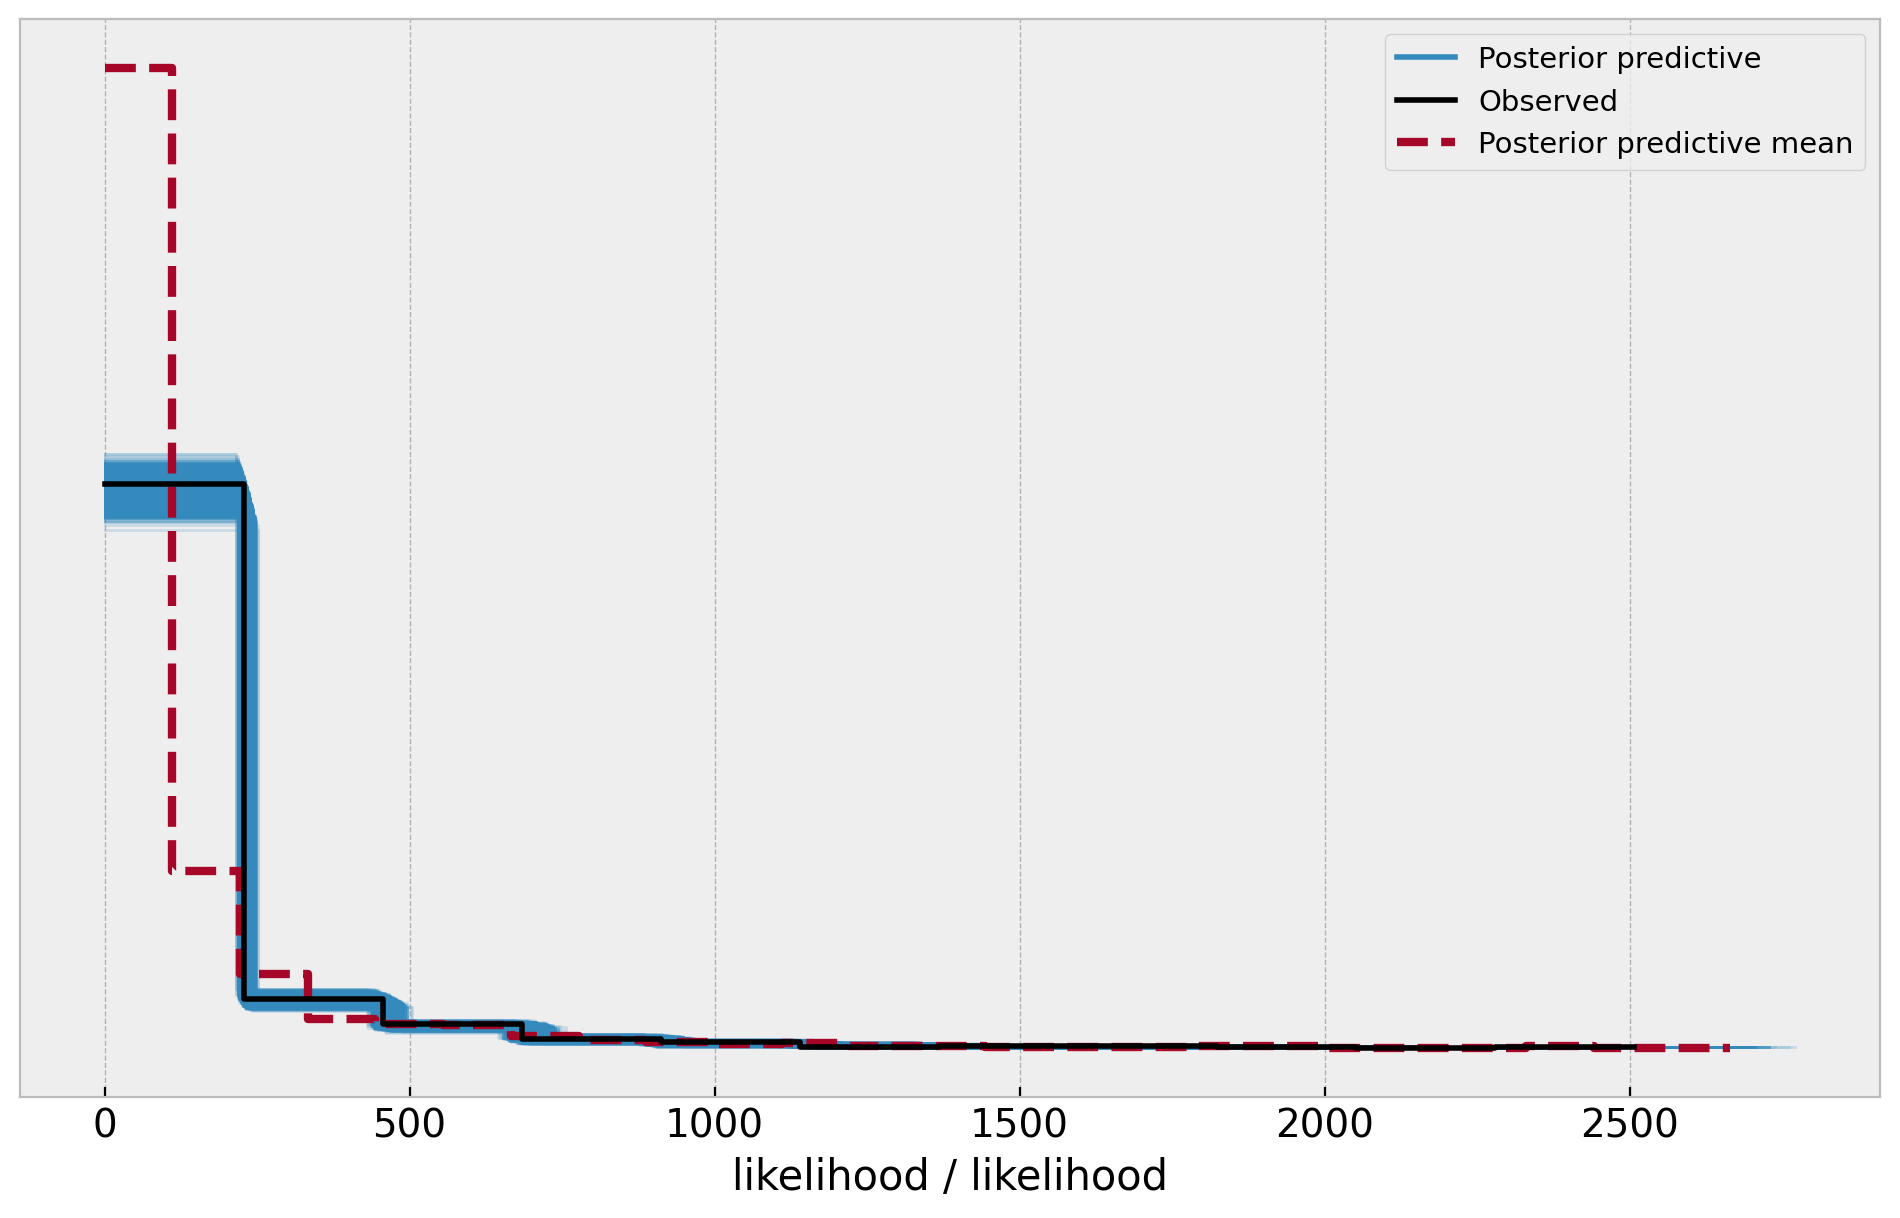

In [17]:
az.plot_ppc(data=posterior_predictive)

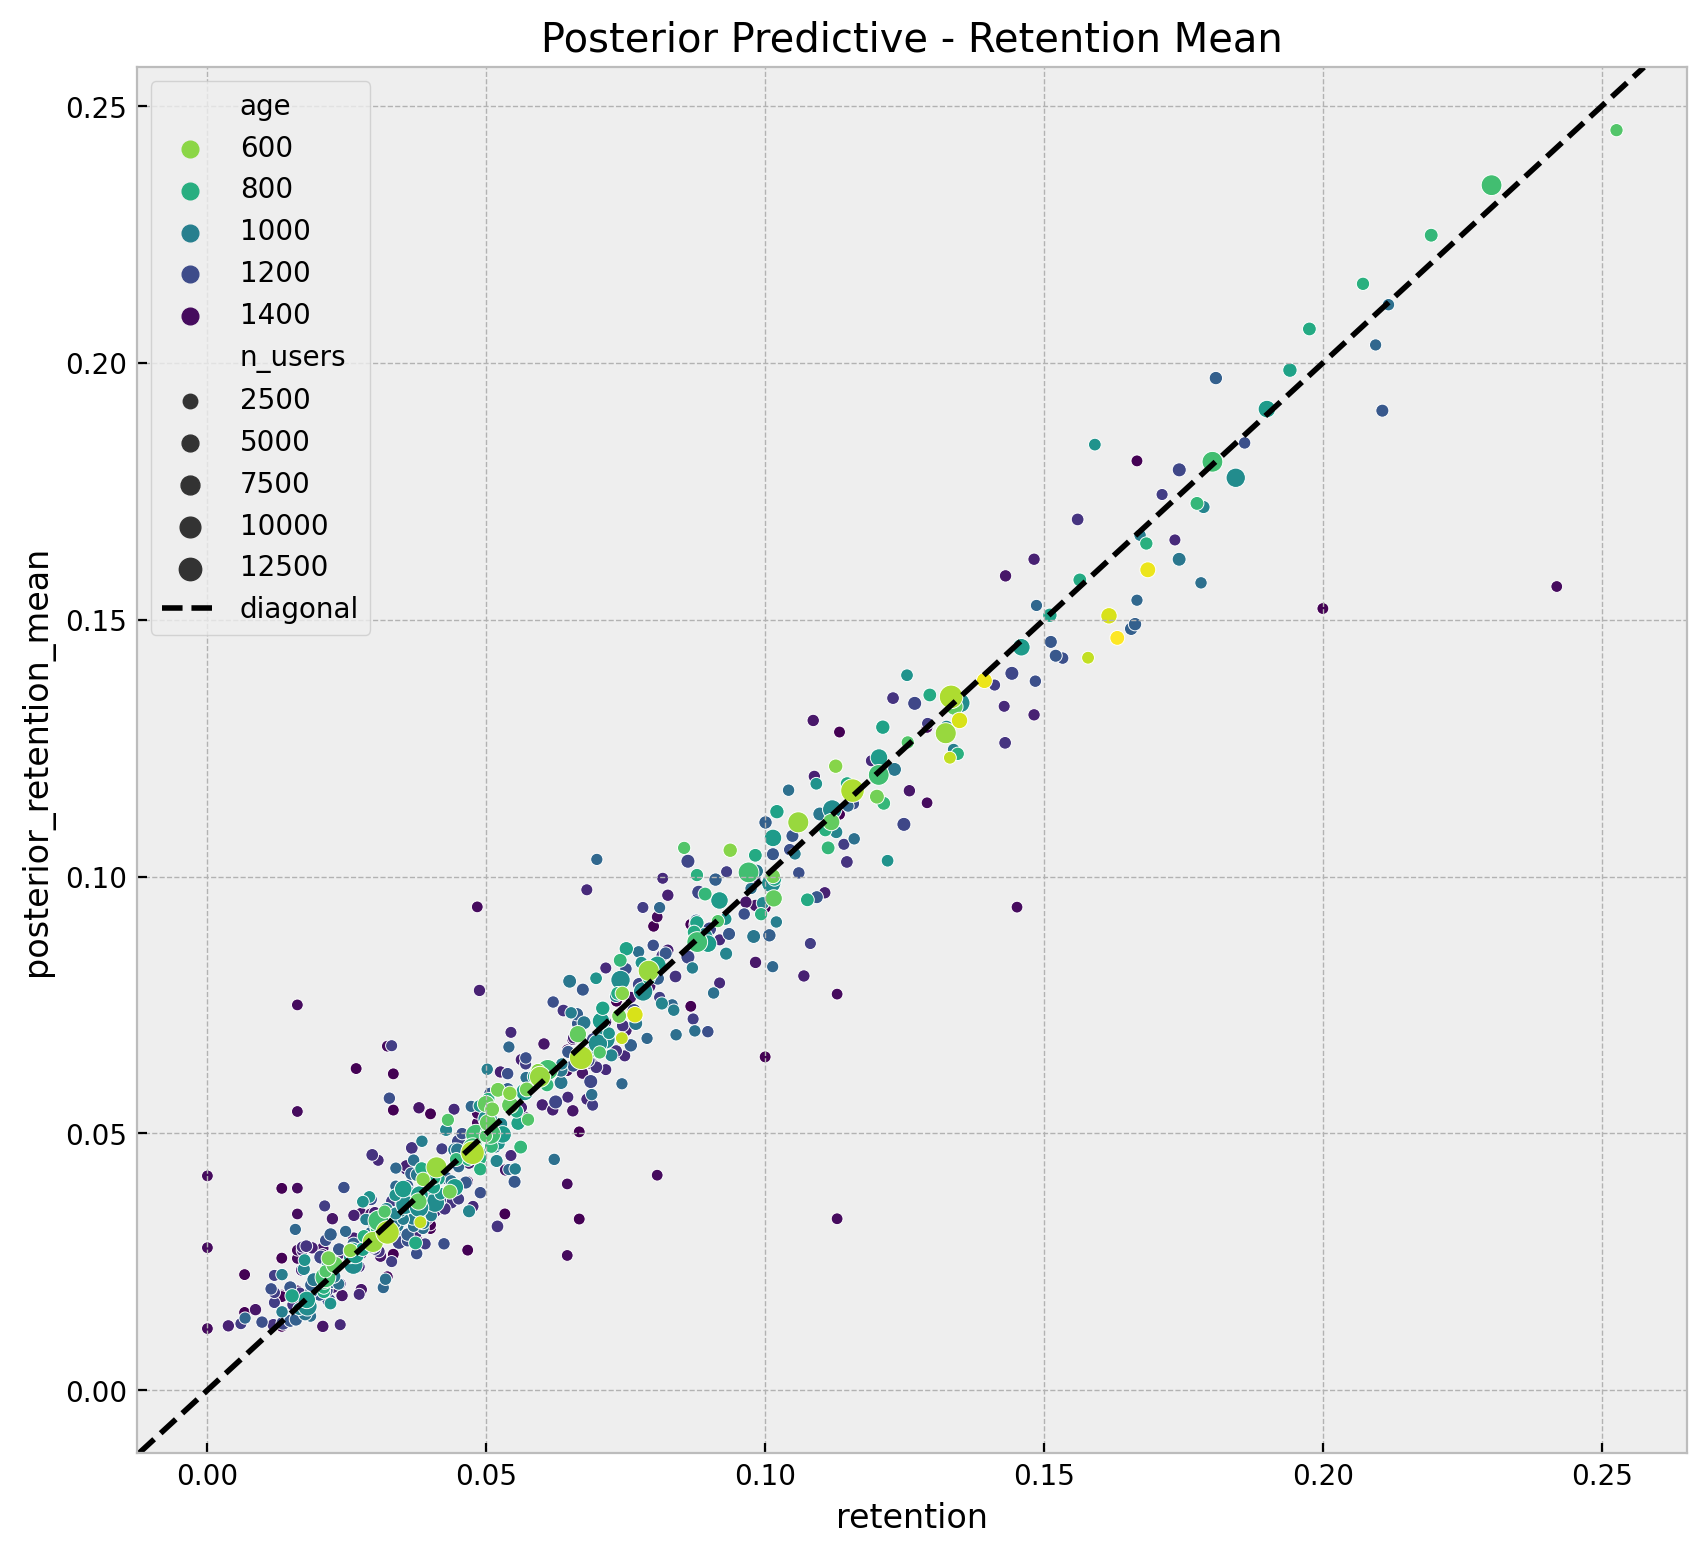

In [18]:
train_posterior_retention = (
    posterior_predictive.posterior_predictive / train_n_users[np.newaxis, None]
)
train_posterior_retention_mean = az.extract(
    data=train_posterior_retention, var_names=["likelihood"]
).mean("sample")

fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(
    x="retention",
    y="posterior_retention_mean",
    data=train_data_red_df.assign(
        posterior_retention_mean=train_posterior_retention_mean
    ),
    hue="age",
    palette="viridis_r",
    size="n_users",
    ax=ax,
)
ax.axline(xy1=(0, 0), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(title="Posterior Predictive - Retention Mean");

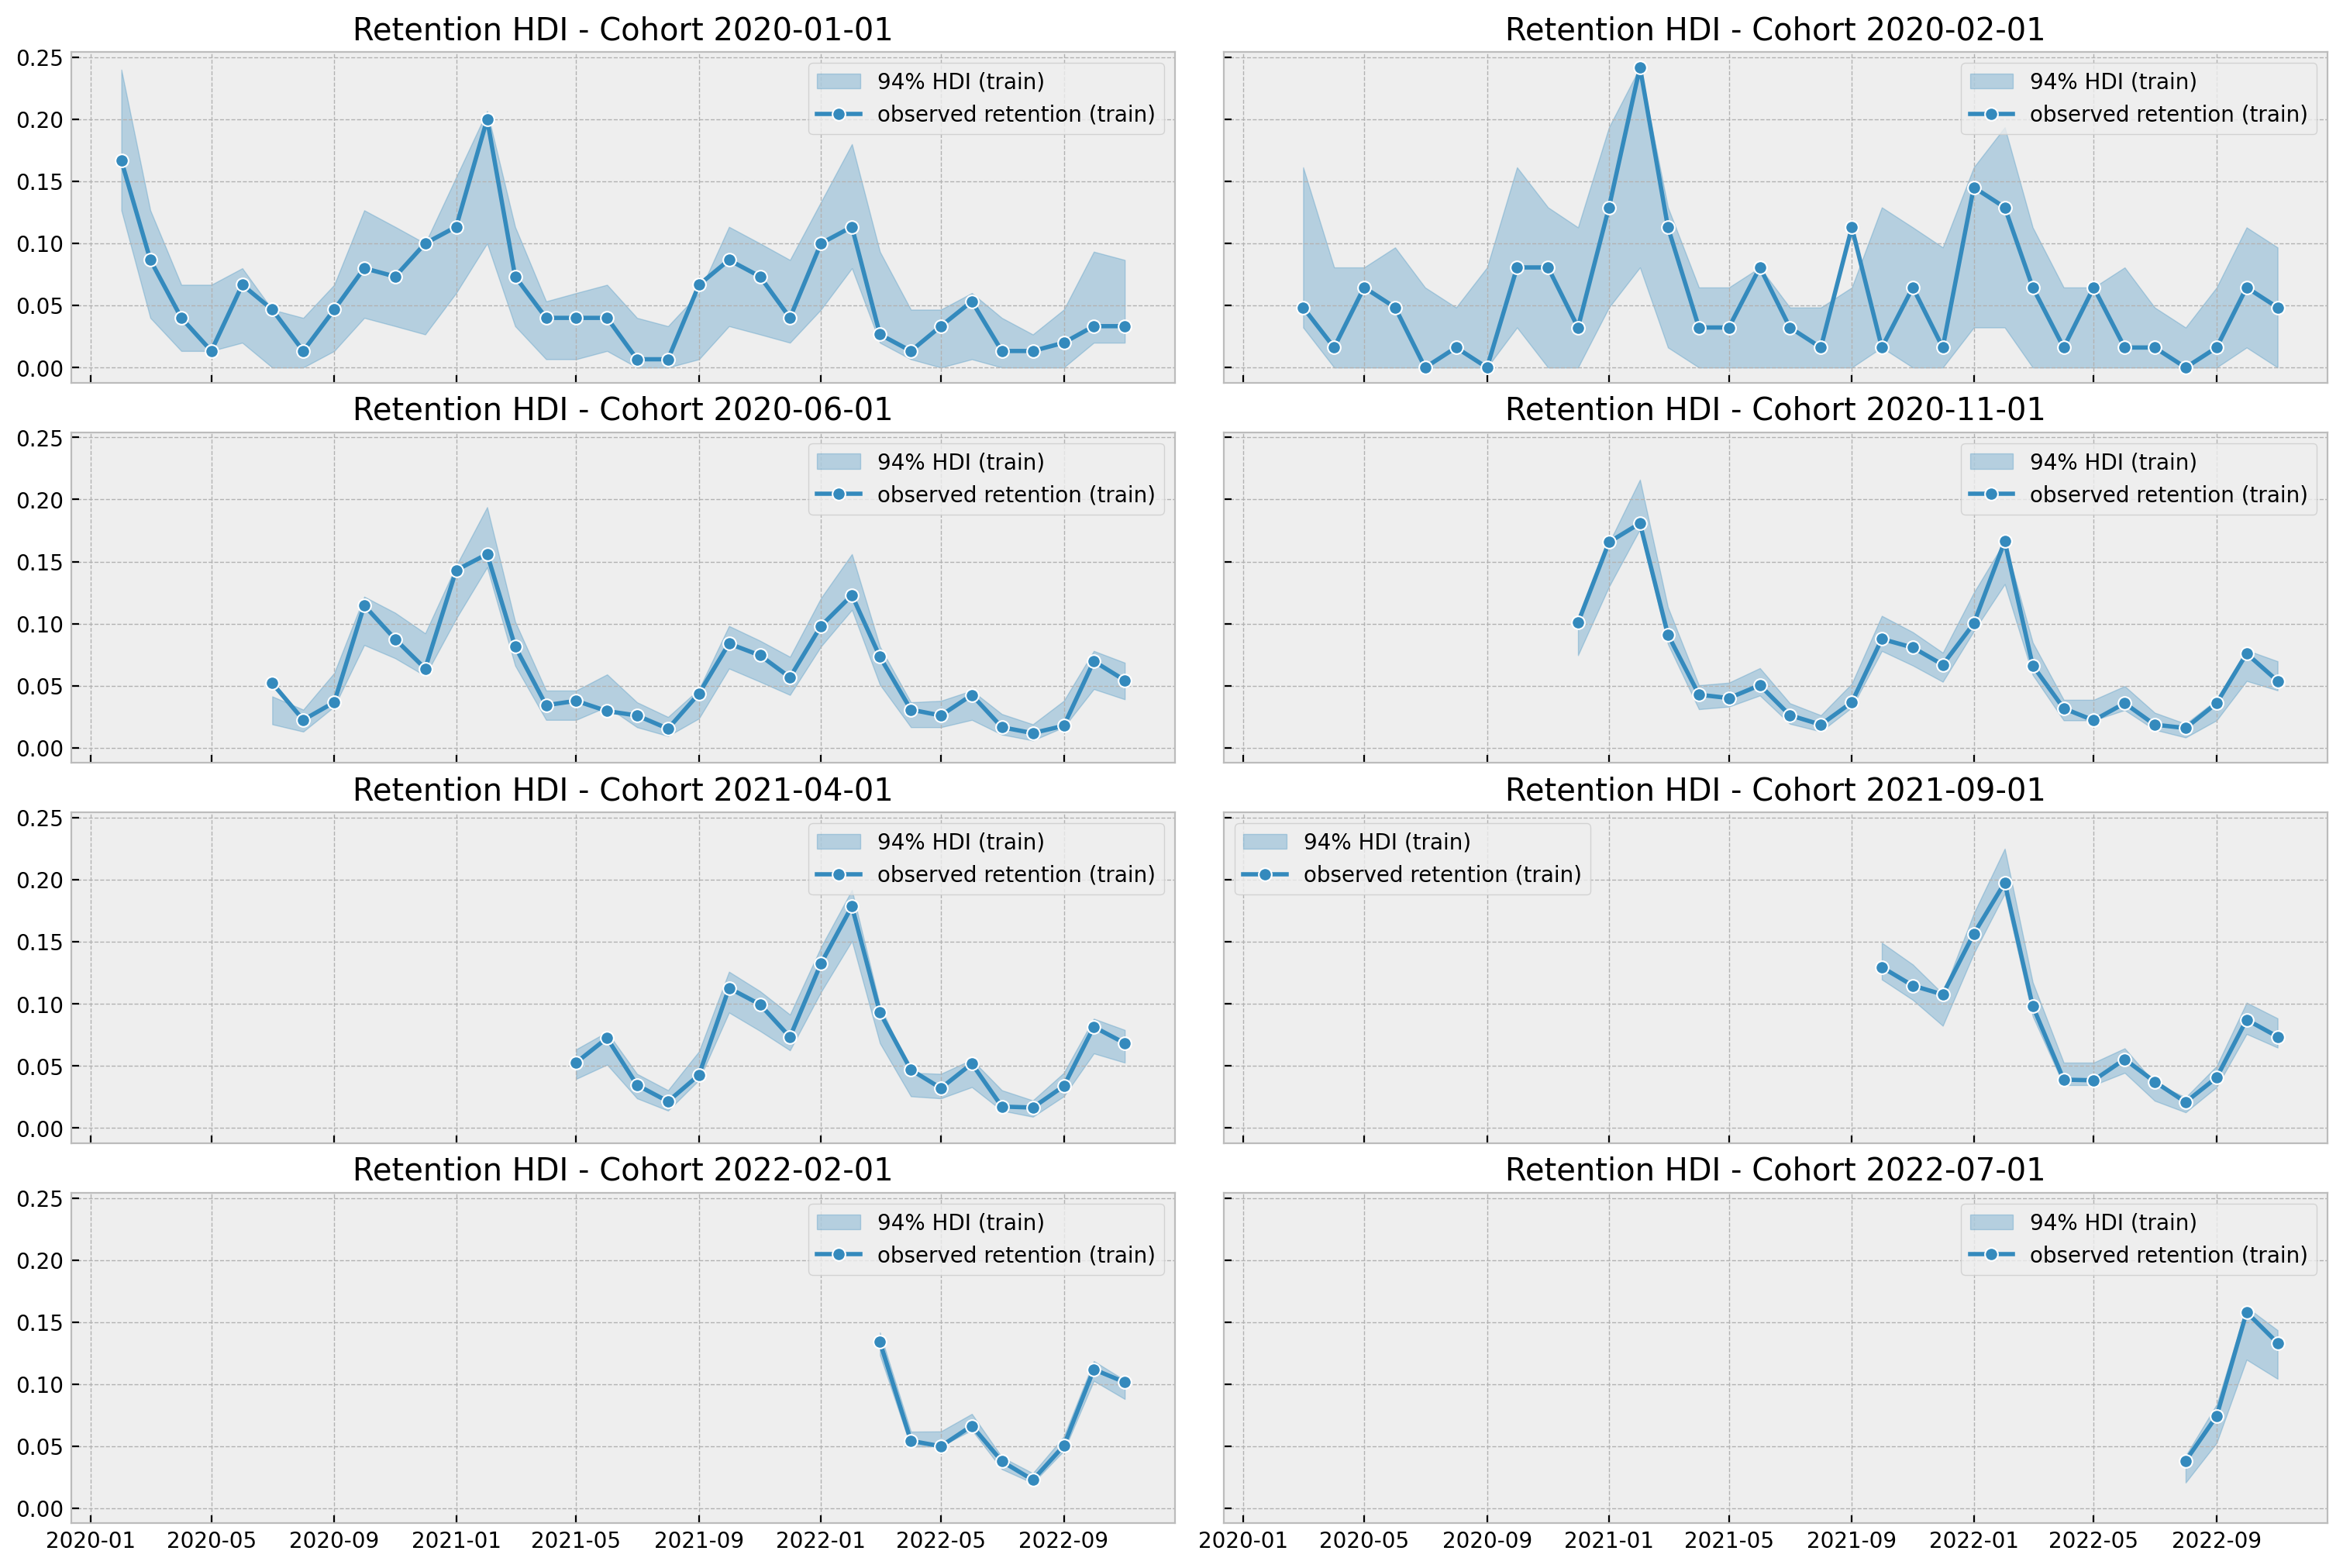

In [19]:
train_retention_hdi = az.hdi(ary=train_posterior_retention)["likelihood"]


def plot_train_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:

    mask = train_cohort_idx == cohort_index

    ax.fill_between(
        x=train_period[train_period_idx[mask]],
        y1=train_retention_hdi[mask, :][:, 0],
        y2=train_retention_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C0",
        label="94% HDI (train)",
    )
    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=train_retention[mask],
        color="C0",
        marker="o",
        label="observed retention (train)",
        ax=ax,
    )
    cohort_name = (
        pd.to_datetime(train_cohort_encoder.classes_[cohort_index]).date().isoformat()
    )
    ax.set(title=f"Retention HDI - Cohort {cohort_name}")
    return ax


cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=np.ceil(len(cohort_index_to_plot) / 2).astype(int),
    ncols=2,
    figsize=(15, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten()):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)

## Predictions

In [20]:
test_data_red_df = test_data_df.query("cohort_age > 0")
test_data_red_df = test_data_red_df[test_data_red_df["cohort"].isin(train_data_red_df['cohort'].unique())].reset_index(drop=True)
test_obs_idx = test_data_red_df.index.to_numpy()
test_n_users = test_data_red_df["n_users"].to_numpy()
test_n_active_users = test_data_red_df["n_active_users"].to_numpy()
test_retention = test_data_red_df["retention"].to_numpy()

# Continuous features
test_cohort = test_data_red_df["cohort"].to_numpy()
test_cohort_idx = train_cohort_encoder.transform(test_cohort).flatten()
test_age = test_data_red_df["age"].to_numpy()
test_age_scaled = train_age_scaler.transform(test_age.reshape(-1, 1)).flatten()
test_cohort_age = test_data_red_df["cohort_age"].to_numpy()
test_cohort_age_scaled = train_cohort_age_scaler.transform(test_cohort_age.reshape(-1, 1)).flatten()

# Categorical features
test_period_month = test_data_red_df["period"].dt.month.to_numpy()
test_period_month_idx = train_period_month_encoder.fit_transform(test_period_month).flatten()

In [21]:
with model:
    pm.set_data(
        new_data={
            "age_scaled": test_age_scaled,
            "cohort_age_scaled": test_cohort_age_scaled,
            "period_month_idx": test_period_month_idx,
            "n_users": test_n_users,
            "n_active_users": test_n_active_users,
        },
        coords={"obs": test_obs_idx},
    )
    idata.extend(
        pm.sample_posterior_predictive(
            trace=idata,
            var_names=["likelihood", "p", "mu"],
            idata_kwargs={"coords": {"obs": test_obs_idx}},
        )
    )

Sampling: [likelihood]
INFO:pymc:Sampling: [likelihood]


In [22]:
test_posterior_retention = (
    idata.posterior_predictive["likelihood"] / test_n_users[np.newaxis, None]
)

test_retention_hdi = az.hdi(ary=test_posterior_retention)["likelihood"]

In [23]:
def plot_test_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = test_cohort_idx == cohort_index

    test_period_range = test_data_red_df.query(f"cohort == '{train_cohort_encoder.classes_[cohort_index]}'")["period"]

    ax.fill_between(
        x=test_period_range,
        y1=test_retention_hdi[mask, :][:, 0],
        y2=test_retention_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C1",
        label="94% HDI (test)",
    )
    sns.lineplot(
        x=test_period_range,
        y=test_retention[mask],
        color="C1",
        marker="o",
        label="observed retention (test)",
        ax=ax,
    )
    return ax

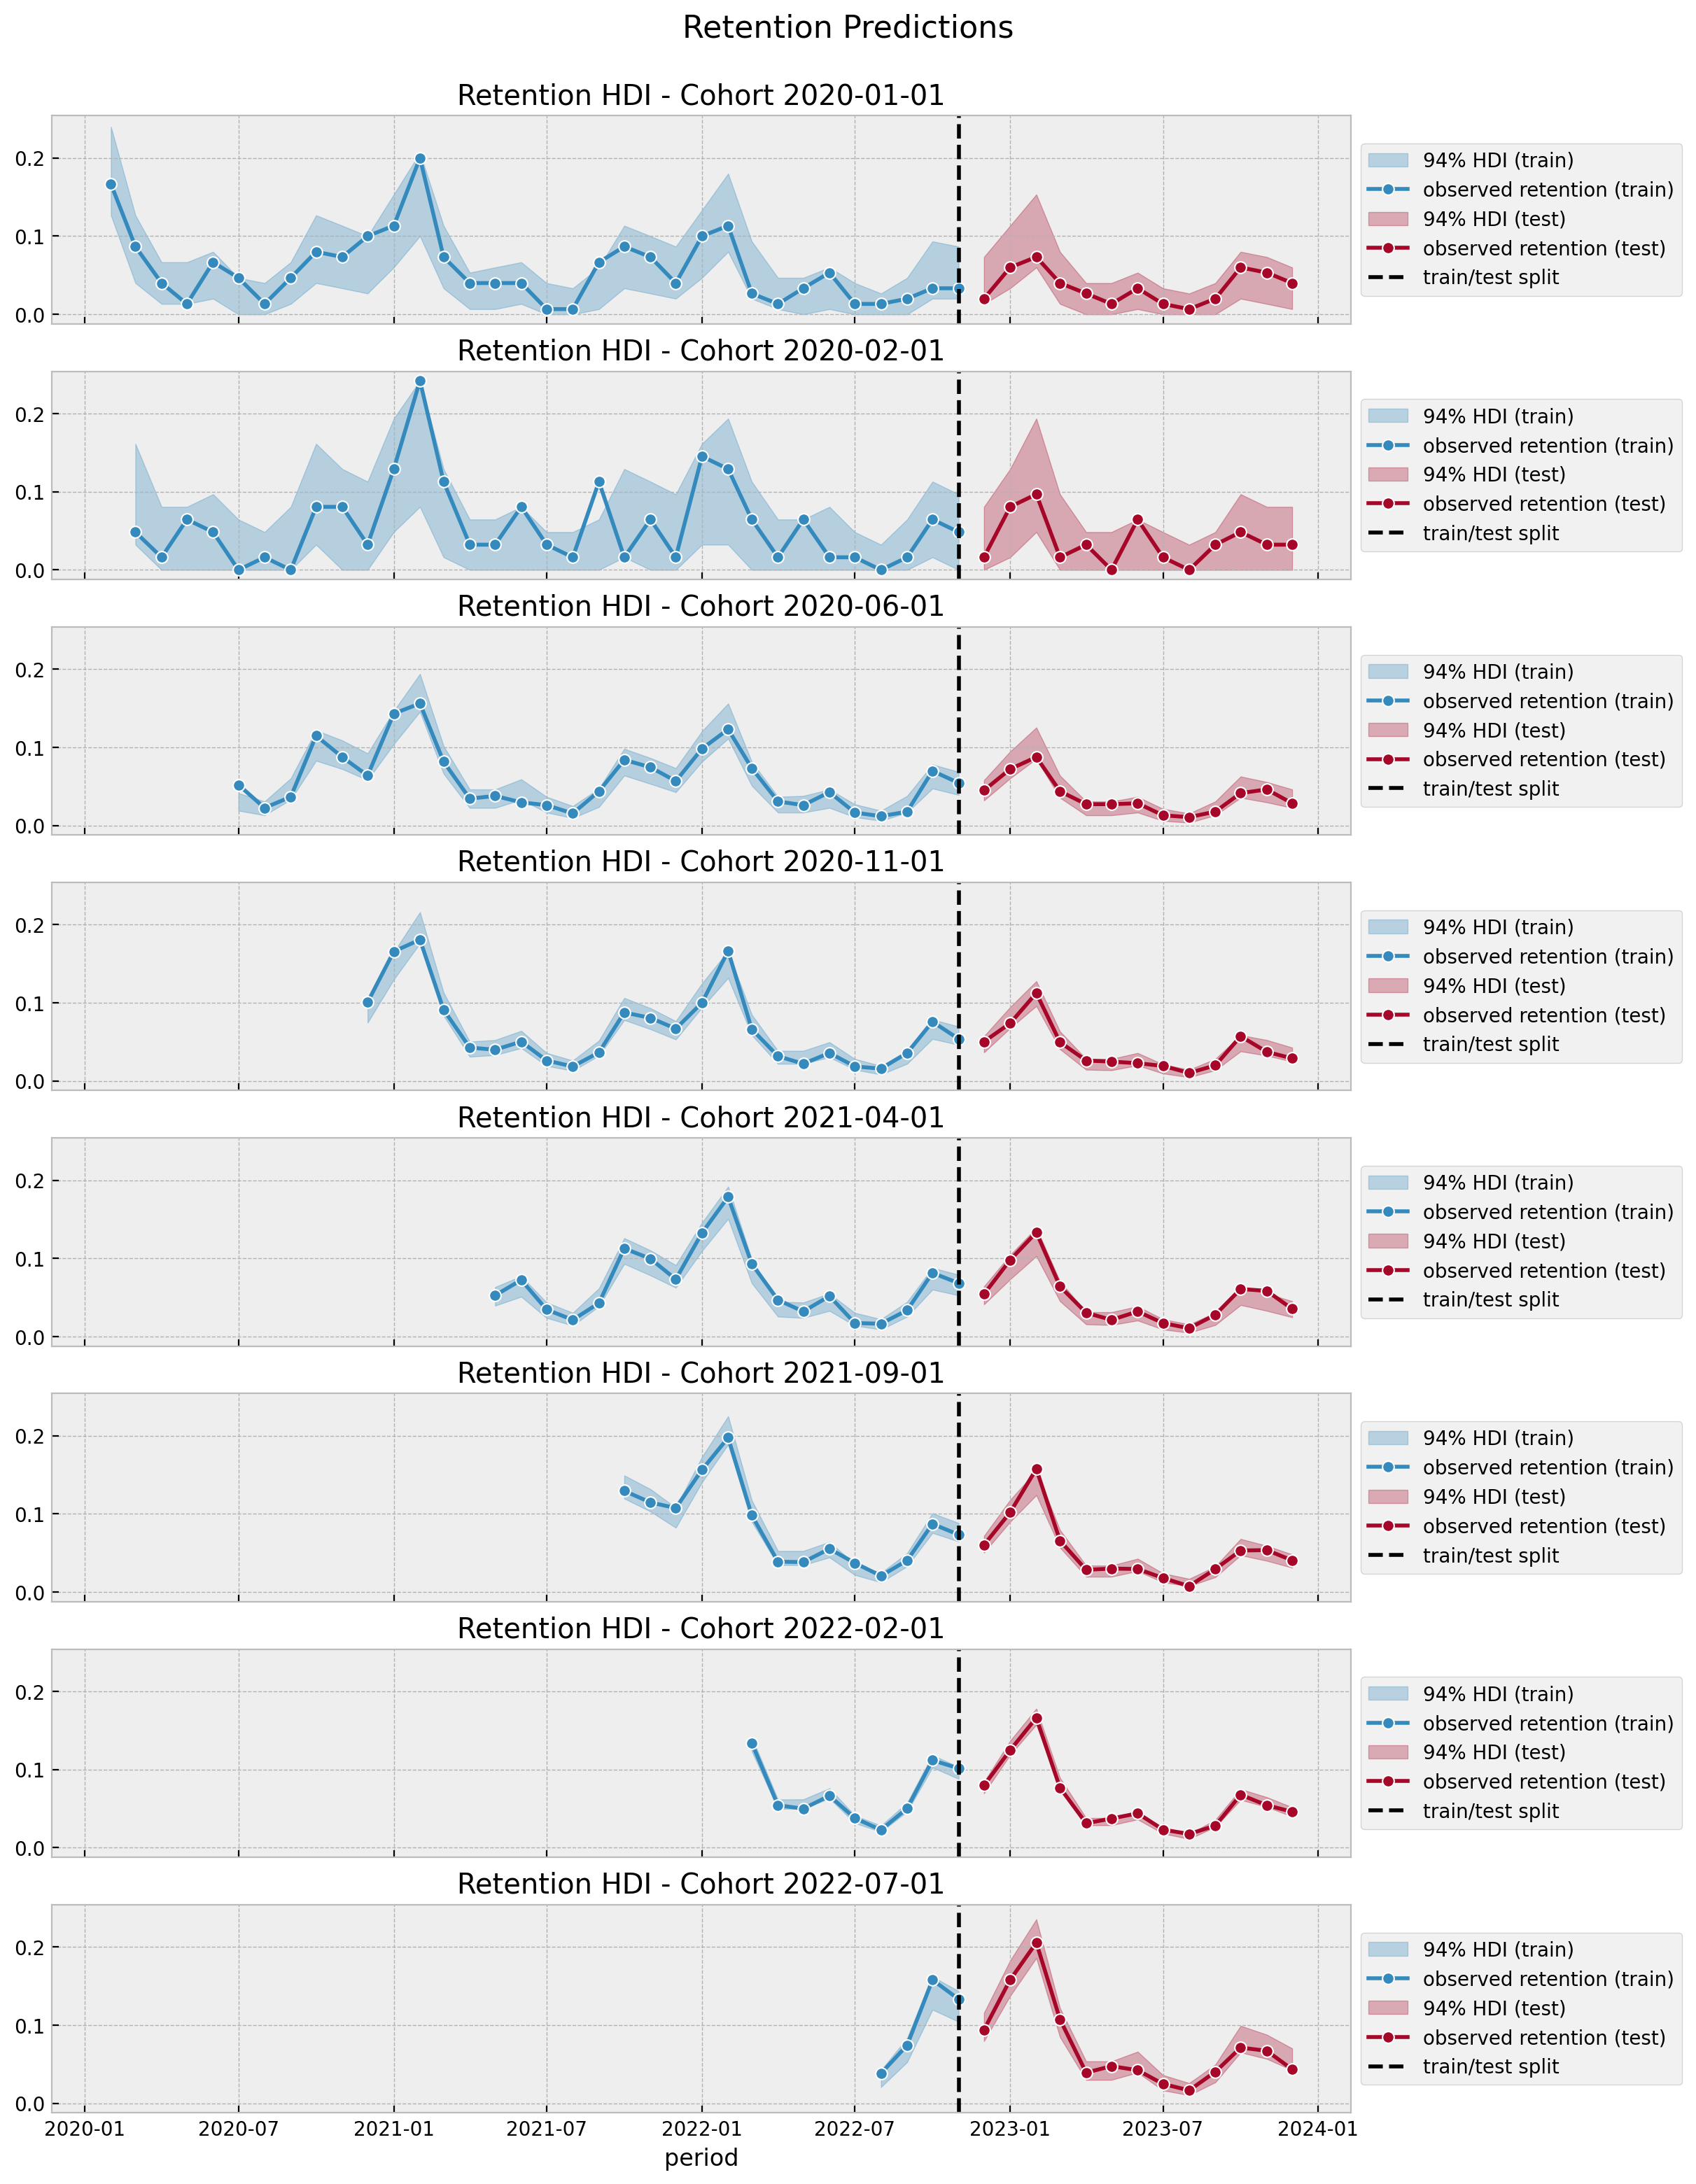

In [24]:
cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=len(cohort_index_to_plot),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten()):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    plot_test_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    ax.axvline(
        x=pd.to_datetime(period_train_test_split),
        color="black",
        linestyle="--",
        label="train/test split",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.suptitle("Retention Predictions", y=1.03, fontsize=16);